In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

# 加载cifar10数据集

In [2]:
import paddle # 导入paddle库
import paddle.fluid as fluid
from paddle.vision.datasets import Cifar10
from paddle.vision.transforms import Compose, Normalize,ToTensor,ColorJitter,RandomHorizontalFlip
import matplotlib.pyplot as plt
from PIL import Image  

# data_format='HWC'
transform = Compose([ColorJitter(),RandomHorizontalFlip(),ToTensor()])

cifar10 = Cifar10(mode='train', download=False,data_file ="data/data46154/cifar-10.tar.gz", transform=transform)
train_loader = paddle.io.DataLoader(cifar10, batch_size=32, shuffle=True)

cifar10 = Cifar10(mode='test', download=False,data_file ="data/data46154/cifar-10.tar.gz",transform=ToTensor())
test_loader = paddle.io.DataLoader(cifar10, batch_size=32, shuffle=True)

for batch_id, data in enumerate(train_loader()):
    x_data = data[0]
    y_data = data[1]
    break

print(x_data.numpy().shape)
print(y_data.numpy().shape)
# for batch_id, data in enumerate(test_loader()):
#     # x_data包括批量原始图片和转换过的图片
#     x_data = data[0]
#     # 一个批量的标签
#     y_data = data[1]
    
#     # 一个批量的原始图片
#     print(x_data[0].shape)
#     # 一个批量的转换图片
#     print(x_data[1].shape)

#     # print(x_data[0].numpy()[0])

#     #表示第i张图片，下标只能从1开始，不能从0，
#     plt.subplot(1,2,1)
#     plt.title(y_data[0].numpy())
#     plt.imshow(x_data[0].numpy(),cmap=plt.cm.gray)
#     plt.subplot(1,2,2)
#     plt.title(y_data[1].numpy())
#     plt.imshow(x_data[1].numpy(),cmap=plt.cm.gray)
 
#     #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
#     # plt.xticks([])
#     # plt.yticks([])
#     plt.show()
#     break

W0620 20:54:45.839506   193 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0620 20:54:45.843395   193 device_context.cc:465] device: 0, cuDNN Version: 7.6.


(32, 3, 32, 32)
(32,)


# 使用vgg19/vgg16预训练网络

In [ ]:
# import paddle
# from paddle.vision.models import VGG
# from paddle.vision.models.vgg import make_layers

# cfgs = {
#     'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
#     'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
# }

# features = make_layers(cfgs['vgg19'])

# myModel = VGG(features,num_classes=10)

# my = paddle.Model(myModel)
# my.summary((1,3,32,32))

In [ ]:
import paddle.nn as nn
from paddle.vision.models import vgg19,vgg16

class VGG(nn.Layer):
    def __init__(self , model):
        super(VGG, self).__init__()

        self.client = nn.Sequential(*list(model.children())[0][:4])

        self.server = nn.Sequential(
            *list(model.children())[0][4:],
            list(model.children())[1]
        )

        self.fc = nn.Sequential(
            *list(model.children())[2]
            # paddle.nn.Linear(512*7*7,4096),
            # paddle.nn.Linear(4096,2048),
            # paddle.nn.Linear(2048,200)
        )

    def forward(self, x):
        x = self.client(x)
        
        featuremap = x

        x = self.server(x)

        x = paddle.flatten(x, start_axis=1,stop_axis=-1)

        x = self.fc(x)

        return featuremap,x

# myModel = VGG19(vgg16(pretrained= True,num_classes = 10))
# my = paddle.Model(myModel)
# my.summary((1,3,32,32))

In [15]:
import paddle.nn as nn
import paddle

class MyVGG16(nn.Layer):
    def __init__(self):
        super(MyVGG16, self).__init__()

        self.client = nn.Sequential(
            nn.Conv2D(3, 64, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(64, 64, kernel_size=[3, 3], padding=1),
            nn.ReLU()
        )

        self.serve = nn.Sequential(
            nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
            nn.Conv2D(64, 128, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(128, 128, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
            nn.Conv2D(128, 256, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(256, 256, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(256, 256, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
            nn.Conv2D(256, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(512, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(512, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
            nn.Conv2D(512, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(512, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(512, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
        )

        self.Adaptive = nn.AdaptiveAvgPool2D(output_size=(7, 7))

        self.fc = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=10),
        )

    def forward(self, x,flag = False):

        x = self.client(x)

        feature = x

        if flag == True:
            return feature

        x = self.serve(x)

        x = self.Adaptive(x)

        x = paddle.flatten(x, start_axis=1,stop_axis=-1)

        x = self.fc(x)

        return feature,x

# myModel = MyVGG16()
# my = paddle.Model(myModel)
# my.summary((1,3,32,32))

# 使用自定义网络

In [24]:
import paddle.nn.functional as F
class MyNet(paddle.nn.Layer):
    def __init__(self, num_classes=1):
        super(MyNet, self).__init__()

        self.conv1 = paddle.nn.Conv2D(in_channels=3, out_channels=32, kernel_size=(3, 3))
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        self.conv2 = paddle.nn.Conv2D(in_channels=32, out_channels=64, kernel_size=(3,3))
        self.pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        self.conv3 = paddle.nn.Conv2D(in_channels=64, out_channels=64, kernel_size=(3,3))

        self.flatten = paddle.nn.Flatten()

        self.linear1 = paddle.nn.Linear(in_features=1024, out_features=64)
        self.linear2 = paddle.nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x


# 自定义的预训练

In [ ]:
import os, cv2
import paddle.nn.functional as F
from paddle.fluid.dygraph import to_variable, save_dygraph
from paddle.vision.models import vgg19,vgg16
import numpy as np

def train(epoch_num = 1000,use_gpu = True, load_model = True,dataSet="MNIST",meath="Mosaic",modelName="MLP"):

    place = paddle.CUDAPlace(0) if use_gpu else paddle.CPUPlace()

    # 多级目录
    savePath = os.path.join(dataSet+"_"+modelName,meath)
    
    if not os.path.exists(savePath):
        os.makedirs(savePath)

    with paddle.fluid.dygraph.guard(place):
        # 实例化模型
        if modelName=="MyNet":
            model = MyNet(num_classes=10)
        elif modelName=="vgg16":
            model = MyVGG16()
        elif modelName=="vgg19":
            # features = make_layers(cfgs[modelName])
            # model = VGG(features,num_classes=10)

            # model = vgg19(num_classes=10)
            # model = VGG("VGG", num_classes=10,layer=19)
            model = VGG(vgg19(num_classes = 10))
 
        # 配置优化器
        scheduler = paddle.optimizer.lr.ExponentialDecay(learning_rate=0.0001, gamma=0.1, verbose=True)
        opt = paddle.optimizer.Momentum(learning_rate=scheduler,parameters=model.parameters())
        if load_model and os.path.exists(savePath):
            model_para, model_opt = paddle.fluid.load_dygraph(savePath+"/"+modelName)
            model.load_dict(model_para)
            # opt.load_dict(model_opt)

            # cnt = 0
            # for name, value in model.named_parameters():
            #     # if cnt < 17:
            #     if cnt < 7:
            #     # if name[:2] != "fc":
            #         value.stop_gradient = True
            #         cnt = cnt+1
        # 模型训练
        model.train()
        print('Start training...')
        for epoch in range(epoch_num):
            for batch_id, data in enumerate(train_loader()):
                x_data = data[0]
                y_data = paddle.to_tensor(data[1])
                y_data = paddle.unsqueeze(y_data, 1)

                _,pre = model(x_data)
                avg_loss = F.cross_entropy(input=pre, label=y_data)

                if batch_id % 100 == 0:
                    print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))

                avg_loss.backward()
                opt.step()
                opt.clear_grad()
            
            if (epoch+1) % 20 == 0:
                scheduler.step()

            if (epoch+1) % 10 ==0:
                    save_dygraph(model.state_dict(),os.path.join(savePath,modelName))
                    # save_dygraph(opt.state_dict(),os.path.join(savePath,modelName))

            # 模型验证
            model.eval()
            accuracies = []
            losses = []
            for batch_id, data in enumerate(test_loader()):
                x_data = data[0]
                y_data = paddle.to_tensor(data[1])
                y_data = paddle.unsqueeze(y_data, 1)

                _,pre = model(x_data)
                # 获取预测结果
                loss = F.cross_entropy(pre, y_data)
                acc = paddle.metric.accuracy(pre, y_data)
                accuracies.append(acc.numpy())
                losses.append(loss.numpy())

            avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
            print("[Test] accuracy/loss: {}/{}".format(avg_acc, avg_loss))
            model.train()
            
        # 模型保存
        # save_dygraph(opt.state_dict(), os.path.join(savePath,modelName))
        save_dygraph(model.state_dict(),os.path.join(savePath,modelName))


In [ ]:
train(epoch_num=100,load_model=True,dataSet="Cifar10",meath="no",modelName="vgg16")

In [ ]:
train(epoch_num=30,load_model=True,dataSet="Cifar10",meath="no",modelName="vgg19")

# 测试预训练网络

In [ ]:
import numpy as np

# d = VGG19(vgg19(num_classes = 10))
# model_para, _ = fluid.load_dygraph("Cifar10_vgg19/no/vgg19")

d = MyVGG16()
model_para, _ = fluid.load_dygraph("Cifar10_vgg16/no/vgg16")

d.load_dict(model_para)

acc = []
for batch_id, data in enumerate(test_loader()):
    x_data = data[0]
    y_data = paddle.to_tensor(data[1])
    y_data = paddle.unsqueeze(y_data, 1)
    

    _,pre = d(x_data)

    acc.append(paddle.metric.accuracy(pre, y_data).numpy())

print(np.mean(acc))

0.85658836


# 重构网络

## 自定义重构网络

In [9]:
import paddle
import paddle.nn as nn
from math import sqrt,log

class myObfuscator(nn.Layer):
    def __init__(self):
        super(myObfuscator, self).__init__()

        self.encode = nn.Sequential(
            nn.Conv2D(3, 32, kernel_size=[3, 3], stride=2, padding=1, data_format='NCHW'),
            nn.BatchNorm2D(num_features=32, momentum=0.9, epsilon=1e-05),
            nn.LeakyReLU(),
        
            nn.Conv2D(32,64, kernel_size=[3, 3], stride=1, padding="SAME", data_format='NCHW'),
            nn.BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05),
            nn.LeakyReLU(),

            nn.Conv2D(64,128, kernel_size=[3, 3], stride=2, padding=1, data_format='NCHW'),
            nn.BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05),
            nn.LeakyReLU(),

            nn.Conv2D(128,128, kernel_size=[3, 3], stride=[2, 2], padding=1, data_format='NCHW'),
            nn.BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05),
            nn.LeakyReLU()
        )

        self.decode = nn.Sequential(
            # nn.Conv2DTranspose(in_channels=128,out_channels=128,kernel_size=3,stride=2, padding="VALID"),
            # nn.Tanh(),
            nn.Conv2DTranspose(in_channels=128,out_channels=64,kernel_size=2,stride=2, padding="VALID"),
            nn.Tanh(),
            nn.Conv2DTranspose(in_channels=64,out_channels=32,kernel_size=2,stride=2, padding=0),
            nn.Tanh(),
            nn.Conv2DTranspose(in_channels=32,out_channels=3,kernel_size=2,stride=2, padding=0),
            nn.Tanh()
        )

    def forward(self, x):
 
        x = self.encode(x)
        x = self.decode(x)

        return x

# myModel = myObfuscator()
# my = paddle.Model(myModel)
# my.summary((1,3,32,32))

## 复现论文的重构网络

In [13]:
import paddle
import paddle.nn as nn
from math import sqrt,log,ceil

class BottleneckBlock(nn.Layer):
    def __init__(self, in_channels, out_channels,stride, padding):
        super(BottleneckBlock, self).__init__()

        self.mm = int(in_channels * 6)

        self.bottleneck = nn.Sequential(
            nn.Conv2D(in_channels, self.mm, kernel_size=[1, 1], data_format='NCHW'),
            nn.BatchNorm2D(num_features=self.mm, momentum=0.9, epsilon=1e-05),
            nn.LeakyReLU(),
        
            nn.Conv2D(self.mm, self.mm, kernel_size=[3, 3], stride=stride, padding=padding, groups=self.mm, data_format='NCHW'),
            nn.BatchNorm2D(num_features=self.mm, momentum=0.9, epsilon=1e-05),
            nn.LeakyReLU(),
        
            nn.Conv2D(self.mm, out_channels, kernel_size=[1, 1], data_format='NCHW'),
            nn.BatchNorm2D(num_features=out_channels, momentum=0.9, epsilon=1e-05)
        )
  
    def forward(self, x):
        x = self.bottleneck(x)
        
        return x;

class UpsampleBottleneckBlock(nn.Layer):
    def __init__(self, in_channels, out_channels,stride, padding):
        super(UpsampleBottleneckBlock, self).__init__()

        self.mm = int(in_channels / 6)

        self.upbottleneck = nn.Sequential(
            nn.Conv2DTranspose(in_channels, self.mm, kernel_size=[1, 1], data_format='NCHW'),
            nn.BatchNorm2D(num_features=self.mm, momentum=0.9, epsilon=1e-05),
            nn.LeakyReLU(),
        
            nn.Conv2DTranspose(self.mm, self.mm, kernel_size=[2, 2], stride=stride, padding=padding, groups=self.mm, data_format='NCHW'),
            nn.BatchNorm2D(num_features=self.mm, momentum=0.9, epsilon=1e-05),
            nn.LeakyReLU(),
        
            nn.Conv2DTranspose(self.mm, out_channels, kernel_size=[1, 1], data_format='NCHW'),
            nn.BatchNorm2D(num_features=out_channels, momentum=0.9, epsilon=1e-05),
            nn.LeakyReLU()
        )
  
    def forward(self, x):
        x = self.upbottleneck(x)
        
        return x;

class Obfuscator(nn.Layer):
    def __init__(self):
        super(Obfuscator, self).__init__()
        
        self.ConvBNReLU = nn.Sequential(
            nn.Conv2D(3, 32, kernel_size=[3, 3], stride=[2, 2], padding=1, data_format='NCHW'),
            nn.BatchNorm2D(num_features=32, momentum=0.9, epsilon=1e-05),
            nn.LeakyReLU()
        )
        
        self.layer1 = self._make_layer(32,64,1,'SAME')

        self.layer2 = self._make_layer(64,128)

        self.layer3 = self._make_layer(128,128)

        self.relayer1 = self._make_layer(128,64,2,0,sample = "up")

        self.relayer2 = self._make_layer(64,32,2,0,sample = "up")

        self.encode = nn.Sequential(
            self.ConvBNReLU,
            self.layer1,
            self.layer2,
            self.layer3
        )

        self.decode = nn.Sequential(
            # nn.Conv2DTranspose(in_channels=128,out_channels=64,kernel_size=1,stride=1),
            # nn.Tanh(),
            # nn.Conv2DTranspose(in_channels=64,out_channels=32,kernel_size=3),
            # nn.Tanh(),
            # nn.Conv2DTranspose(in_channels=32,out_channels=3,kernel_size=3),
            # nn.Tanh()
            # # ,stride=1,padding="SAME"
            self.relayer1,
            self.relayer2,
            nn.Conv2DTranspose(in_channels=32,out_channels=3,kernel_size=2,stride=2,padding=0),
            nn.Tanh()
        )

    def _make_layer(self, in_channel, out_channel,stride=2, padding=1,sample = "down"):
        layers = []
        if sample == "down":
            layers.append(BottleneckBlock(in_channel, out_channel,stride, padding))
        elif sample == "up":
            layers.append(UpsampleBottleneckBlock(in_channel, out_channel,stride, padding))
        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.encode(x)
        # print(x.shape)
        x = self.decode(x)

        return x

myModel = Obfuscator()
my = paddle.Model(myModel)
my.summary((1,3,32,32))

-------------------------------------------------------------------------------------
      Layer (type)            Input Shape          Output Shape         Param #    
        Conv2D-47           [[1, 3, 32, 32]]     [1, 32, 16, 16]          896      
      BatchNorm2D-9        [[1, 32, 16, 16]]     [1, 32, 16, 16]          128      
       LeakyReLU-9         [[1, 32, 16, 16]]     [1, 32, 16, 16]           0       
        Conv2D-48          [[1, 32, 16, 16]]     [1, 192, 16, 16]        6,336     
     BatchNorm2D-10        [[1, 192, 16, 16]]    [1, 192, 16, 16]         768      
      LeakyReLU-10         [[1, 192, 16, 16]]    [1, 192, 16, 16]          0       
        Conv2D-49          [[1, 192, 16, 16]]    [1, 192, 16, 16]        1,920     
     BatchNorm2D-11        [[1, 192, 16, 16]]    [1, 192, 16, 16]         768      
      LeakyReLU-11         [[1, 192, 16, 16]]    [1, 192, 16, 16]          0       
        Conv2D-50          [[1, 192, 16, 16]]    [1, 64, 16, 16]        12

{'total_params': 323221, 'trainable_params': 310429}

## UNet
U-Net网络结构因为形似字母“U”而得名，最早是在医学影像的细胞分割任务中提出，结构简单适合处理小数量级的数据集。比较于FCN网络的像素相加，U-Net是对通道进行concat操作，保留上下文信息的同时，加强了它们之间的语义联系。整体是一个Encode-Decode的结构

In [10]:
import paddle
from paddle import nn

class Encoder(nn.Layer):#下采样：两层卷积，两层归一化，最后池化。
    def __init__(self, num_channels, num_filters):
        super(Encoder,self).__init__()#继承父类的初始化
        self.conv1 = nn.Conv2D(in_channels=num_channels,
                              out_channels=num_filters,
                              kernel_size=3,#3x3卷积核，步长为1，填充为1，不改变图片尺寸[H W]
                              stride=1,
                              padding=1)
        self.bn1   = nn.BatchNorm(num_filters,act="relu")#归一化，并使用了激活函数
        
        self.conv2 = nn.Conv2D(in_channels=num_filters,
                              out_channels=num_filters,
                              kernel_size=3,
                              stride=1,
                              padding=1)
        self.bn2   = nn.BatchNorm(num_filters,act="relu")
        
        self.pool  = nn.MaxPool2D(kernel_size=2,stride=2,padding="SAME")#池化层，图片尺寸减半[H/2 W/2]
        
    def forward(self,inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x_conv = x           #两个输出，灰色 ->
        x_pool = self.pool(x)#两个输出，红色 | 
        return x_conv, x_pool
    
    
class Decoder(nn.Layer):#上采样：一层反卷积，两层卷积层，两层归一化
    def __init__(self, num_channels, num_filters):
        super(Decoder,self).__init__()
        self.up = nn.Conv2DTranspose(in_channels=num_channels,
                                    out_channels=num_filters,
                                    kernel_size=2,
                                    stride=2,
                                    padding=0)#图片尺寸变大一倍[2*H 2*W]

        self.conv1 = nn.Conv2D(in_channels=num_filters*2,
                              out_channels=num_filters,
                              kernel_size=3,
                              stride=1,
                              padding=1)
        self.bn1   = nn.BatchNorm(num_filters,act="relu")
        
        self.conv2 = nn.Conv2D(in_channels=num_filters,
                              out_channels=num_filters,
                              kernel_size=3,
                              stride=1,
                              padding=1)
        self.bn2   = nn.BatchNorm(num_filters,act="relu")
        
    def forward(self,input_conv,input_pool):
        x = self.up(input_pool)
        h_diff = (input_conv.shape[2]-x.shape[2])
        w_diff = (input_conv.shape[3]-x.shape[3])
        pad = nn.Pad2D(padding=[h_diff//2, h_diff-h_diff//2, w_diff//2, w_diff-w_diff//2])
        x = pad(x)                                #以下采样保存的feature map为基准，填充上采样的feature map尺寸
        x = paddle.concat(x=[input_conv,x],axis=1)#考虑上下文信息，in_channels扩大两倍
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return x
    
class UNet(nn.Layer):
    def __init__(self,num_classes=32):
        super(UNet,self).__init__()
        self.down1 = Encoder(num_channels=  3, num_filters=64) #下采样
        self.down2 = Encoder(num_channels= 64, num_filters=128)
        self.down3 = Encoder(num_channels=128, num_filters=256)
        self.down4 = Encoder(num_channels=256, num_filters=512)
        
        self.mid_conv1 = nn.Conv2D(512,1024,1)                 #中间层
        self.mid_bn1   = nn.BatchNorm(1024,act="relu")
        self.mid_conv2 = nn.Conv2D(1024,1024,1)
        self.mid_bn2   = nn.BatchNorm(1024,act="relu")

        self.up4 = Decoder(1024,512)                           #上采样
        self.up3 = Decoder(512,256)
        self.up2 = Decoder(256,128)
        self.up1 = Decoder(128,64)
        
        self.last_conv = nn.Conv2D(64,num_classes,1)           #1x1卷积，softmax做分类
        
    def forward(self,inputs):
        x1, x = self.down1(inputs)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x4, x = self.down4(x)
        
        x = self.mid_conv1(x)
        x = self.mid_bn1(x)
        x = self.mid_conv2(x)
        x = self.mid_bn2(x)
        
        x = self.up4(x4, x)
        x = self.up3(x3, x)
        x = self.up2(x2, x)
        x = self.up1(x1, x)
        
        x = self.last_conv(x)
        
        return x
        
paddle.summary(UNet(3), (1, 3, 32, 32))

----------------------------------------------------------------------------------------------------------
  Layer (type)                Input Shape                        Output Shape                Param #    
    Conv2D-5               [[1, 3, 32, 32]]                    [1, 64, 32, 32]                1,792     
   BatchNorm-1             [[1, 64, 32, 32]]                   [1, 64, 32, 32]                 256      
    Conv2D-6               [[1, 64, 32, 32]]                   [1, 64, 32, 32]               36,928     
   BatchNorm-2             [[1, 64, 32, 32]]                   [1, 64, 32, 32]                 256      
   MaxPool2D-1             [[1, 64, 32, 32]]                   [1, 64, 16, 16]                  0       
    Encoder-1              [[1, 3, 32, 32]]           [[1, 64, 32, 32], [1, 64, 16, 16]]        0       
    Conv2D-7               [[1, 64, 16, 16]]                   [1, 128, 16, 16]              73,856     
   BatchNorm-3            [[1, 128, 16, 16]]         

{'total_params': 18472515, 'trainable_params': 18448963}

In [11]:
import paddle
import paddle.nn as nn

class myObfuscatorAndUNet(nn.Layer):
    def __init__(self,a,b):
        super(myObfuscatorAndUNet, self).__init__()

        self.a = a
        self.b = b

        self.branch1 = myObfuscator()

        self.branch2 = UNet(3)

    def forward(self, x):
 
        out1 = self.branch1(x)
        out2 = self.branch2(x)

        out = self.a * out1 + self.b * out2

        return out

myModel = myObfuscatorAndUNet(0.3,0.7)
my = paddle.Model(myModel)
my.summary((1,3,32,32))

-----------------------------------------------------------------------------------------------------------
   Layer (type)                Input Shape                        Output Shape                Param #    
    Conv2D-24               [[1, 3, 32, 32]]                    [1, 32, 16, 16]                 896      
  BatchNorm2D-5             [[1, 32, 16, 16]]                   [1, 32, 16, 16]                 128      
   LeakyReLU-5              [[1, 32, 16, 16]]                   [1, 32, 16, 16]                  0       
    Conv2D-25               [[1, 32, 16, 16]]                   [1, 64, 16, 16]               18,496     
  BatchNorm2D-6             [[1, 64, 16, 16]]                   [1, 64, 16, 16]                 256      
   LeakyReLU-6              [[1, 64, 16, 16]]                   [1, 64, 16, 16]                  0       
    Conv2D-26               [[1, 64, 16, 16]]                    [1, 128, 8, 8]               73,856     
  BatchNorm2D-7             [[1, 128, 8, 8]]

{'total_params': 18756198, 'trainable_params': 18731238}

## 更复杂网络——使用SRResnet网络

In [ ]:
from paddle.nn import Layer
from paddle import nn

class ResBlock(Layer):
    def __init__(self,inChannels,outChannels):
        super(ResBlock, self).__init__()
        self.cov1=nn.Conv2D(kernel_size=3,out_channels=outChannels,in_channels=inChannels,stride=1,padding=3//2)
        self.Bn1=nn.BatchNorm2D(num_features=outChannels)
        self.prelu = nn.PReLU()
        self.cov2=nn.Conv2D(kernel_size=3,out_channels=outChannels,in_channels=inChannels,stride=1,padding=3//2)
        self.Bn2=nn.BatchNorm2D(num_features=outChannels)

    def forward(self,input):
        x=input
        input=self.cov1(input)
        input=self.Bn1(input)
        input=self.prelu(input)
        input=self.cov2(input)
        input=self.Bn2(input)

        input+=x

        return x

class SRResnet(Layer):
    def __init__(self,inChannels,outChannels):
        super(SRResnet, self).__init__()
        # 卷积层
        self.cov1 = nn.Conv2D(3, outChannels, kernel_size=9, stride=2, padding=9 // 2)
        self.prelu1 = nn.PReLU()

        # 卷积层
        self.cov1_1 = nn.Conv2D(outChannels, outChannels, kernel_size=9, stride=2, padding=9 // 2)
        self.prelu1_1 = nn.PReLU()
    
        # 残差层
        self.Resblock = self.getRes(ResBlock, 64, 64, 16)
    
        # 卷积层
        self.cov2 = nn.Conv2D(inChannels, outChannels, kernel_size=3, stride=1, padding=3 // 2)
        self.Bn1 = nn.BatchNorm2D(outChannels)
    
        # # 子像素卷积块
        # self.cov3 = nn.Conv2D(inChannels, outChannels * 4, kernel_size=3, stride=1, padding=3 // 2)
        # self.PixelShuffle1 = nn.PixelShuffle(2)
        # self.prelu2 = nn.PReLU()
        # self.cov4 = nn.Conv2D(inChannels, outChannels * 4, kernel_size=3, stride=1, padding=3 // 2)
        # self.PixelShuffle2 = nn.PixelShuffle(2)
        # self.prelu3 = nn.PReLU()

        self.cov3 = nn.Conv2D(inChannels, outChannels * 4, kernel_size=3, stride=1, padding=3 // 2)
        self.PixelShuffle1 = nn.PixelShuffle(2)
        self.prelu2 = nn.PReLU()
        self.cov4 = nn.Conv2D(inChannels, outChannels * 4, kernel_size=3, stride=1, padding=3 // 2)
        self.PixelShuffle2 = nn.PixelShuffle(2)
        self.prelu3 = nn.PReLU()
    
    
        # 最后的卷积模块
        self.cov5 = nn.Conv2D(inChannels, 3, kernel_size=9, stride=1, padding=9 // 2)
        self.tanh=nn.Tanh()

    def getRes(self,block,inChannels,outChannels,num):
        return nn.Sequential(*[block(inChannels,outChannels) for i in range(num)])

    def forward(self,input):
        input=self.cov1(input)
        input=self.prelu1(input)

        input=self.cov1_1(input)
        input=self.prelu1_1(input)

        x = input
        input=self.Resblock(input)

        input=self.cov2(input)
        input=self.Bn1(input)

        input+=x

        input=self.cov3(input)
        input=self.PixelShuffle1(input)
        input=self.prelu2(input)
        input=self.cov4(input)
        input=self.PixelShuffle2(input)
        input=self.prelu3(input)

        input=self.cov5(input)
        input=self.tanh(input)

        return input

myModel = SRResnet(64,64)
my = paddle.Model(myModel)
my.summary((1,3,32,32))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-34      [[1, 3, 32, 32]]     [1, 64, 16, 16]        15,616     
    PReLU-1      [[1, 64, 16, 16]]     [1, 64, 16, 16]           1       
   Conv2D-35     [[1, 64, 16, 16]]      [1, 64, 8, 8]         331,840    
    PReLU-2       [[1, 64, 8, 8]]       [1, 64, 8, 8]            1       
   Conv2D-36      [[1, 64, 8, 8]]       [1, 64, 8, 8]         36,928     
BatchNorm2D-33    [[1, 64, 8, 8]]       [1, 64, 8, 8]           256      
    PReLU-3       [[1, 64, 8, 8]]       [1, 64, 8, 8]            1       
   Conv2D-37      [[1, 64, 8, 8]]       [1, 64, 8, 8]         36,928     
BatchNorm2D-34    [[1, 64, 8, 8]]       [1, 64, 8, 8]           256      
  ResBlock-1      [[1, 64, 8, 8]]       [1, 64, 8, 8]            0       
   Conv2D-38      [[1, 64, 8, 8]]       [1, 64, 8, 8]         36,928     
BatchNorm2D-35    [[1, 64, 8, 8]]   

{'total_params': 1885527, 'trainable_params': 1877079}

# gan思想训练转换

## 第一篇论文

In [ ]:
import os, cv2
import paddle.nn.functional as F
from paddle.fluid.dygraph import to_variable, save_dygraph

def train(epoch_num=10, batch_size=128, use_gpu=True, load_model=False):
    # 使用GPU
    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()

    with fluid.dygraph.guard(place):
        # 模型存储路径
        model_path = './output2/'

        # 分别定义转换、重构、判别对象
        g = Obfuscator()
        g.train()
        reg = Obfuscator()
        reg.train()
        
        # 注意：别忘记写分类数
        # d = VGG(vgg19(num_classes = 10))
        d = MyVGG16()
        model_para, _ = fluid.load_dygraph("Cifar10_vgg16/no/vgg16")
        d.load_dict(model_para)
        d.eval()

        # # 定义优化器对象,判别网络是预训练好的，不需要改动的。
        # g_optimizer = paddle.optimizer.Adam(learning_rate=0.0001, parameters=g.parameters())
        # reg_optimizer = paddle.optimizer.Adam(learning_rate=0.0001, parameters=reg.parameters())

        # 配置优化器
        scheduler = paddle.optimizer.lr.ExponentialDecay(learning_rate=0.001, gamma=0.1, verbose=True)
        g_optimizer = paddle.optimizer.Momentum(learning_rate=scheduler,parameters=g.parameters())
        reg_optimizer = paddle.optimizer.Momentum(learning_rate=scheduler, parameters=reg.parameters())
       
        # 读取上次保存的模型
        if load_model == True:
            g_para, g_opt = paddle.fluid.load_dygraph(model_path+'g')
            reg_para, reg_opt = paddle.fluid.load_dygraph(model_path+'reg')
       
            g.load_dict(g_para)
            # g_optimizer.set_dict(g_opt)
            reg.load_dict(reg_para)
            # reg_optimizer.set_dict(reg_opt)

        iteration_num = 0
        for epoch in range(epoch_num):
            for i, data in enumerate(train_loader()):
                real_image = data[0]
                y_data = paddle.to_tensor(data[1])
                y_data = paddle.unsqueeze(y_data, 1)
                
                # 丢弃不满整个batch_size的数据
                if(len(real_image) != batch_size):
                    continue
                
                iteration_num += 1
                
                '''
                重构网络reg：使用g的输出作为输入，原始图像作为标签进行训练。
                '''
                # # g对真实图片进行转换，reg对g转换过的真实图片进行重构
                # reImage = reg(g(real_image))
                # # 计算均方损失
                # real_avg_cost = F.mse_loss(reImage,real_image)
                # # 反向传播更新reg的参数
                # real_avg_cost.backward()
                # reg_optimizer.minimize(real_avg_cost)
                # reg.clear_gradients()

                '''
                转换网络g：生成的图片使得判别网络g能识别，且重构网络reg不能重构。
                '''
                # 转换网络g对图片进行转换
                transform_image = g(real_image)
                # 判别网络对转换的图片进行识别
                _,pre = d(transform_image)
                # 计算识别交叉熵损失
                d_cost = F.cross_entropy(pre, y_data)

                # 重构网络对转换的图片进行重构
                regImage = reg(transform_image)
                # 计算重构均方损失
                reg_cost = F.mse_loss(regImage, real_image)
                

                reg_cost.backward(retain_graph=True)
                reg_optimizer.minimize(reg_cost)
                reg.clear_gradients()

                

                # 反向传播更新g的参数
                total_loss = d_cost - reg_cost
                total_loss.backward()
                g_optimizer.minimize(total_loss)
                g.clear_gradients()
                
                # 打印输出
                if(iteration_num % 100 == 0):
                    print('epoch =', epoch, ', batch =', i, ', reg_loss =', reg_cost.numpy(), 'g_loss =', total_loss.numpy())
                    # show_image_grid(fake.numpy(), BATCH_SIZE, epoch)
            if (epoch+1) % 10 == 0:
                scheduler.step()
                fluid.save_dygraph(g.state_dict(), model_path+'g')
                fluid.save_dygraph(reg.state_dict(), model_path+'reg')
        # 存储模型
        fluid.save_dygraph(g.state_dict(), model_path+'g')
        # fluid.save_dygraph(g_optimizer.state_dict(), model_path+'g')
        fluid.save_dygraph(reg.state_dict(), model_path+'reg')
        # fluid.save_dygraph(reg_optimizer.state_dict(), model_path+'reg')

In [ ]:
train(epoch_num=101, batch_size=32, use_gpu=True, load_model=True)

In [ ]:
# import os, cv2
# import paddle.nn.functional as F
# from paddle.fluid.dygraph import to_variable, save_dygraph

# def train(epoch_num=10, batch_size=128, use_gpu=True, load_model=False):
#     # 使用GPU
#     place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()

#     with fluid.dygraph.guard(place):
#         # 模型存储路径
#         model_path = './output/'

#         # 分别定义转换、重构、判别对象
#         g = myObfuscator()
#         g.train()
#         reg = myObfuscator()
#         reg.train()
        
#         # 注意：别忘记写分类数
#         d = MyNet(10)
#         model_para, _ = fluid.load_dygraph("Cifar10_vgg19/no/vgg16")
#         d.load_dict(model_para)
#         d.eval()

#         # 定义优化器对象,判别网络是预训练好的，不需要改动的。
#         g_optimizer = fluid.optimizer.AdamOptimizer(learning_rate=2e-4, parameter_list=g.parameters())
#         reg_optimizer = fluid.optimizer.AdamOptimizer(learning_rate=2e-4, parameter_list=reg.parameters())
       
#         # 读取上次保存的模型
#         if load_model == True:
#             g_para, g_opt = fluid.load_dygraph(model_path+'g')
#             reg_para, reg_opt = fluid.load_dygraph(model_path+'reg')
       
#             g.load_dict(g_para)
#             g_optimizer.set_dict(g_opt)
#             reg.load_dict(reg_para)
#             reg_optimizer.set_dict(reg_opt)

#         iteration_num = 0
#         for epoch in range(epoch_num):
#             for i, data in enumerate(train_loader()):
#                 real_image = data[0]
#                 y_data = paddle.to_tensor(data[1])
#                 y_data = paddle.unsqueeze(y_data, 1)
                
#                 # 丢弃不满整个batch_size的数据
#                 if(len(real_image) != batch_size):
#                     continue
                
#                 iteration_num += 1
                
#                 '''
#                 重构网络reg：使用g的输出作为输入，原始图像作为标签进行训练。
#                 '''
#                 # g对真实图片进行转换，reg对g转换过的真实图片进行重构
#                 reImage = reg(g(real_image))
#                 # 计算均方损失
#                 real_avg_cost = F.mse_loss(reImage,real_image)
#                 # 反向传播更新reg的参数
#                 real_avg_cost.backward()
#                 reg_optimizer.minimize(real_avg_cost)
#                 reg.clear_gradients()
                
#                 '''
#                 转换网络g：生成的图片使得判别网络g能识别，且重构网络reg不能重构。
#                 '''
#                 # 转换网络g对图片进行转换
#                 transform_image = g(real_image)
#                 # 判别网络对转换的图片进行识别
#                 pre = d(transform_image)
#                 # 计算识别交叉熵损失
#                 d_cost = F.cross_entropy(pre, y_data)

#                 # 重构网络对转换的图片进行重构
#                 regImage = reg(transform_image)
#                 # 计算重构均方损失
#                 reg_cost = F.mse_loss(regImage, real_image)

#                 # 反向传播更新g的参数
#                 total_loss = d_cost - reg_cost
#                 total_loss.backward()
#                 g_optimizer.minimize(total_loss)
#                 g.clear_gradients()
                
#                 # 打印输出
#                 if(iteration_num % 100 == 0):
#                     print('epoch =', epoch, ', batch =', i, ', reg_loss =', real_avg_cost.numpy(), 'g_loss =', total_loss.numpy())
#                     # show_image_grid(fake.numpy(), BATCH_SIZE, epoch)
        
#         # 存储模型
#         fluid.save_dygraph(g.state_dict(), model_path+'g')
#         fluid.save_dygraph(g_optimizer.state_dict(), model_path+'g')
#         fluid.save_dygraph(reg.state_dict(), model_path+'reg')
#         fluid.save_dygraph(reg_optimizer.state_dict(), model_path+'reg')

### 测试转换效果

In [ ]:
import numpy as np

# 转换器
# g = myObfuscator()
# model_para, _ = fluid.load_dygraph("output/g")

g = Obfuscator()
model_para, _ = fluid.load_dygraph("output2/g")
g.load_dict(model_para)

# 识别器
# d = MyNet(10)
# model_para, _ = fluid.load_dygraph("Cifar10_vgg19/no/vgg16")

# d = VGG(vgg19(num_classes = 10))
# model_para, _ = fluid.load_dygraph("Cifar10_vgg19/no/vgg19")

d = MyVGG16()
model_para, _ = fluid.load_dygraph("Cifar10_vgg16/no/vgg16")

d.load_dict(model_para)

acc1 = []
acc2 = []
for batch_id, data in enumerate(test_loader()):
    x_data = data[0]
    y_data = paddle.to_tensor(data[1])
    y_data = paddle.unsqueeze(y_data, 1)

    g_image = g(x_data)

    _,pre = d(x_data)
    _,re_pre = d(g_image)

    
    acc1.append(paddle.metric.accuracy(pre,y_data).numpy())
    acc2.append(paddle.metric.accuracy(re_pre,y_data).numpy())

print(np.mean(acc1))
print(np.mean(acc2))

0.8554313
0.6833067


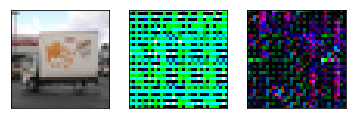

r->d->red:9-9-9
r->d->red:6-6-2
r->d->red:1-1-1
r->d->red:9-1-9
r->d->red:5-5-5
r->d->red:6-8-6
r->d->red:0-0-0
r->d->red:8-8-8
r->d->red:3-3-2
r->d->red:5-5-2
r->d->red:8-8-8
r->d->red:8-6-0
r->d->red:9-6-4
r->d->red:8-8-8
r->d->red:9-9-9
r->d->red:4-4-7
r->d->red:5-5-5
r->d->red:7-7-7
r->d->red:9-9-4
r->d->red:4-3-4
r->d->red:2-2-2
r->d->red:7-7-4
r->d->red:1-1-1
r->d->red:4-5-4
r->d->red:0-0-0
r->d->red:8-8-8
r->d->red:5-5-5
r->d->red:6-6-6
r->d->red:5-5-5
r->d->red:9-9-9
r->d->red:1-1-1
r->d->red:8-8-8
转换前识别的准确个数为26，准确率为0.40625
转换后识别的准确个数为24，准确率为0.375


In [ ]:
import numpy as np

# 重构器
reg = Obfuscator()
model_para, _ = fluid.load_dygraph("output2/reg")
reg.load_dict(model_para)

# 转换器
g = Obfuscator()
model_para, _ = fluid.load_dygraph("output2/g")
g.load_dict(model_para)

# 识别器
# d = MyNet(10)
# model_para, _ = fluid.load_dygraph("Cifar10_vgg19/no/vgg16")

# d = VGG(vgg19(num_classes = 10))
# model_para, _ = fluid.load_dygraph("Cifar10_vgg19/no/vgg19")

d = MyVGG16()
model_para, _ = fluid.load_dygraph("Cifar10_vgg16/no/vgg16")

d.load_dict(model_para)

for batch_id, data in enumerate(test_loader()):
    x_data = data[0]
    y_data = data[1]
    
    g_image = g(x_data)

    _,pre = d(x_data)
    _,re_pre = d(g_image)

    reg_image = reg(g_image)

    image_grid(x_data.numpy().transpose(0,2,3,1)[0],1,3,1)
    image_grid(g_image.numpy().transpose(0,2,3,1)[0],1,3,2)
    image_grid(reg_image.numpy().transpose(0,2,3,1)[0],1,3,3)

    plt.show()
    break

y_data = y_data.numpy()
count1 = 0
count2 = 0
for i in range(32):
    print("r->d->red:{}-{}-{}".format(y_data[i],np.argmax(pre[i]),np.argmax(re_pre[i])))
    if np.argmax(pre[i]) == y_data[i]:
        count1 += 1
    if np.argmax(re_pre[i]) == y_data[i]:
        count2 += 1
print("转换前识别的准确个数为{}，准确率为{}".format(count1,count1 / 64))
print("============================")
print("转换后识别的准确个数为{}，准确率为{}".format(count2,count2 / 64))

## 第二篇论文

### 临时增加一个输出

In [ ]:
import paddle.nn.functional as F
class MyNet(paddle.nn.Layer):
    def __init__(self, num_classes=1):
        super(MyNet, self).__init__()

        self.conv1 = paddle.nn.Conv2D(in_channels=3, out_channels=32, kernel_size=(3, 3))
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        self.conv2 = paddle.nn.Conv2D(in_channels=32, out_channels=64, kernel_size=(3,3))
        self.pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        self.conv3 = paddle.nn.Conv2D(in_channels=64, out_channels=64, kernel_size=(3,3))

        self.flatten = paddle.nn.Flatten()

        self.linear1 = paddle.nn.Linear(in_features=1024, out_features=64)
        self.linear2 = paddle.nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        featuremap = x

        x = self.conv3(x)
        x = F.relu(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return featuremap,x

In [92]:
import os, cv2
import paddle.nn.functional as F
from paddle.fluid.dygraph import to_variable, save_dygraph

def train(epoch_num=10, batch_size=128, use_gpu=True, load_model=False):
    # 使用GPU
    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()

    with paddle.fluid.dygraph.guard(place):
        # 模型存储路径
        model_path = './output_second/'

        # 分别定义转换、判别对象
        # 注意：别忘记写输出通道数
        g = UNet(3)
        g.train()
 
        # 注意：别忘记写分类数
        # d = VGG19(vgg19(num_classes = 10))
        # model_para, _ = fluid.load_dygraph("Cifar10_vgg19/no/vgg19")
        d = MyVGG16()
        model_para, _ = paddle.fluid.load_dygraph("Cifar10_vgg16/no/vgg16")
        d.load_dict(model_para)
        d.eval()

        # 定义优化器对象,判别网络是预训练好的，不需要改动的。
        scheduler = paddle.optimizer.lr.ExponentialDecay(learning_rate=0.01, gamma=0.1, verbose=True)
        g_optimizer = paddle.optimizer.Adam(learning_rate=scheduler, parameters=g.parameters())
        # g_optimizer = paddle.optimizer.Momentum(learning_rate=scheduler,parameters=g.parameters())
   
        # 读取上次保存的模型
        if load_model == True:
            g_para, g_opt = fluid.load_dygraph(model_path+'g')
            reg_para, reg_opt = fluid.load_dygraph(model_path+'reg')
       
            g.load_dict(g_para)
            # g_optimizer.set_dict(g_opt)
            reg.load_dict(reg_para)
            # reg_optimizer.set_dict(reg_opt)

        iteration_num = 0
        for epoch in range(epoch_num):
            for i, data in enumerate(train_loader()):
                real_image = data[0]
                y_data = paddle.to_tensor(data[1])
                y_data = paddle.unsqueeze(y_data, 1)
                
                iteration_num += 1
                
                '''
                转换网络g：生成的图片使得判别网络g能识别，且特征损失变大。
                '''
                # 转换网络g对图片进行转换
                transform_image = g(real_image)
                # 判别网络对原始图片提取特征
                featuremap_o,_ = d(real_image)
                # 判别网络对转换的图片进行识别
                featuremap_t,pre = d(transform_image)
                # 计算识别交叉熵损失
                d_cost = F.cross_entropy(pre, y_data)

                # 特征损失变大
                # print(featuremap_o.shape)
                # print(featuremap_t.shape)
                reg_cost = F.mse_loss(featuremap_o,featuremap_t)
                # print(d_cost.numpy())
                # print(reg_cost.numpy())
                # 反向传播更新g的参数
                total_loss = d_cost - 0.005 * reg_cost
            
                total_loss.backward()
                g_optimizer.minimize(total_loss)
                g.clear_gradients()
                
                # 打印输出
                if(iteration_num % 100 == 0):
                    print('epoch =', epoch, ', batch =', i, 'g_loss =', total_loss.numpy())
                    # show_image_grid(fake.numpy(), BATCH_SIZE, epoch)

            if (epoch+1) % 20 == 0:
                scheduler.step()

            if (epoch+1) % 10 == 0:
                fluid.save_dygraph(g.state_dict(), model_path+'g')

            for img in transform_image.numpy():
                img = img.transpose(1,2,0)
                plt.imshow(img)
                plt.show()
                break;
        # 存储模型
        fluid.save_dygraph(g.state_dict(), model_path+'g')
        # fluid.save_dygraph(g_optimizer.state_dict(), model_path+'g')

Epoch 0: ExponentialDecay set learning rate to 0.01.
epoch = 0 , batch = 99 g_loss = [3.2500648]
epoch = 0 , batch = 199 g_loss = [2.708549]
epoch = 0 , batch = 299 g_loss = [2.6033082]
epoch = 0 , batch = 399 g_loss = [2.520681]
epoch = 0 , batch = 499 g_loss = [2.727453]
epoch = 0 , batch = 599 g_loss = [2.5134652]
epoch = 0 , batch = 699 g_loss = [2.166086]
epoch = 0 , batch = 799 g_loss = [2.034674]
epoch = 0 , batch = 899 g_loss = [1.8902558]
epoch = 0 , batch = 999 g_loss = [2.4271898]
epoch = 0 , batch = 1099 g_loss = [2.2786994]
epoch = 0 , batch = 1199 g_loss = [1.9789261]
epoch = 0 , batch = 1299 g_loss = [2.118348]
epoch = 0 , batch = 1399 g_loss = [2.1409926]
epoch = 0 , batch = 1499 g_loss = [2.1256757]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


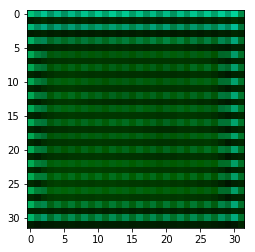

epoch = 1 , batch = 36 g_loss = [1.6937308]
epoch = 1 , batch = 136 g_loss = [2.0807743]
epoch = 1 , batch = 236 g_loss = [1.953958]
epoch = 1 , batch = 336 g_loss = [1.8786159]
epoch = 1 , batch = 436 g_loss = [1.9335138]
epoch = 1 , batch = 536 g_loss = [2.17951]
epoch = 1 , batch = 636 g_loss = [2.058595]
epoch = 1 , batch = 736 g_loss = [2.049201]
epoch = 1 , batch = 836 g_loss = [2.3712223]
epoch = 1 , batch = 936 g_loss = [2.0692232]
epoch = 1 , batch = 1036 g_loss = [1.9445612]
epoch = 1 , batch = 1136 g_loss = [1.7972411]
epoch = 1 , batch = 1236 g_loss = [2.2245293]
epoch = 1 , batch = 1336 g_loss = [1.9138691]
epoch = 1 , batch = 1436 g_loss = [2.1922684]
epoch = 1 , batch = 1536 g_loss = [2.1132605]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


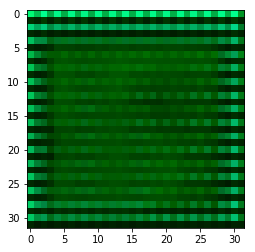

epoch = 2 , batch = 73 g_loss = [2.1287467]
epoch = 2 , batch = 173 g_loss = [1.9151893]
epoch = 2 , batch = 273 g_loss = [2.002584]
epoch = 2 , batch = 373 g_loss = [2.345693]
epoch = 2 , batch = 473 g_loss = [2.2396407]
epoch = 2 , batch = 573 g_loss = [2.1443396]
epoch = 2 , batch = 673 g_loss = [2.2135293]
epoch = 2 , batch = 773 g_loss = [2.0342584]
epoch = 2 , batch = 873 g_loss = [2.1912713]
epoch = 2 , batch = 973 g_loss = [2.2687368]
epoch = 2 , batch = 1073 g_loss = [2.2325835]
epoch = 2 , batch = 1173 g_loss = [2.0404282]
epoch = 2 , batch = 1273 g_loss = [2.0092716]
epoch = 2 , batch = 1373 g_loss = [2.0402784]
epoch = 2 , batch = 1473 g_loss = [2.2803917]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


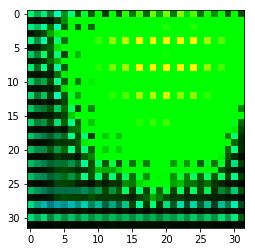

epoch = 3 , batch = 10 g_loss = [1.7026598]
epoch = 3 , batch = 110 g_loss = [1.9228376]
epoch = 3 , batch = 210 g_loss = [1.9690351]
epoch = 3 , batch = 310 g_loss = [2.021957]
epoch = 3 , batch = 410 g_loss = [1.6916136]
epoch = 3 , batch = 510 g_loss = [2.4041984]
epoch = 3 , batch = 610 g_loss = [1.9082218]
epoch = 3 , batch = 710 g_loss = [1.9358401]
epoch = 3 , batch = 810 g_loss = [1.5192457]
epoch = 3 , batch = 910 g_loss = [1.8366477]
epoch = 3 , batch = 1010 g_loss = [2.0085034]
epoch = 3 , batch = 1110 g_loss = [1.920943]
epoch = 3 , batch = 1210 g_loss = [1.9650323]
epoch = 3 , batch = 1310 g_loss = [1.8306453]
epoch = 3 , batch = 1410 g_loss = [1.592881]
epoch = 3 , batch = 1510 g_loss = [2.0638056]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


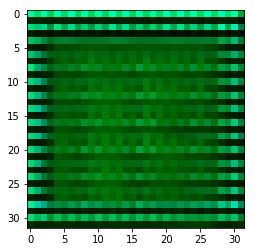

epoch = 4 , batch = 47 g_loss = [1.7410346]
epoch = 4 , batch = 147 g_loss = [2.057047]
epoch = 4 , batch = 247 g_loss = [2.0793245]
epoch = 4 , batch = 347 g_loss = [1.6686866]
epoch = 4 , batch = 447 g_loss = [1.7583374]
epoch = 4 , batch = 547 g_loss = [2.1011949]
epoch = 4 , batch = 647 g_loss = [1.8837945]
epoch = 4 , batch = 747 g_loss = [1.9874791]
epoch = 4 , batch = 847 g_loss = [2.0459137]
epoch = 4 , batch = 947 g_loss = [2.1216495]
epoch = 4 , batch = 1047 g_loss = [2.213326]
epoch = 4 , batch = 1147 g_loss = [2.1014304]
epoch = 4 , batch = 1247 g_loss = [2.1039195]
epoch = 4 , batch = 1347 g_loss = [2.0665421]
epoch = 4 , batch = 1447 g_loss = [1.7891698]
epoch = 4 , batch = 1547 g_loss = [1.9193997]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


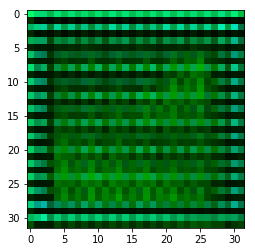

epoch = 5 , batch = 84 g_loss = [2.0530818]
epoch = 5 , batch = 184 g_loss = [1.7766194]
epoch = 5 , batch = 284 g_loss = [2.149505]
epoch = 5 , batch = 384 g_loss = [2.0724592]
epoch = 5 , batch = 484 g_loss = [2.0468388]
epoch = 5 , batch = 584 g_loss = [2.125143]
epoch = 5 , batch = 684 g_loss = [1.9584142]
epoch = 5 , batch = 784 g_loss = [2.0414877]
epoch = 5 , batch = 884 g_loss = [1.9902315]
epoch = 5 , batch = 984 g_loss = [1.8363168]
epoch = 5 , batch = 1084 g_loss = [2.0256581]
epoch = 5 , batch = 1184 g_loss = [2.1787162]
epoch = 5 , batch = 1284 g_loss = [1.9344181]
epoch = 5 , batch = 1384 g_loss = [1.6169024]
epoch = 5 , batch = 1484 g_loss = [1.7195547]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


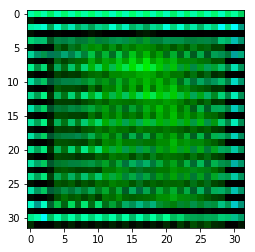

epoch = 6 , batch = 21 g_loss = [1.9581165]
epoch = 6 , batch = 121 g_loss = [2.2154694]
epoch = 6 , batch = 221 g_loss = [1.8232989]
epoch = 6 , batch = 321 g_loss = [1.8691242]
epoch = 6 , batch = 421 g_loss = [2.090953]
epoch = 6 , batch = 521 g_loss = [1.9880612]
epoch = 6 , batch = 621 g_loss = [2.211095]
epoch = 6 , batch = 721 g_loss = [1.9113137]
epoch = 6 , batch = 821 g_loss = [1.9424257]
epoch = 6 , batch = 921 g_loss = [1.752876]
epoch = 6 , batch = 1021 g_loss = [1.8392353]
epoch = 6 , batch = 1121 g_loss = [2.1528537]
epoch = 6 , batch = 1221 g_loss = [1.8482211]
epoch = 6 , batch = 1321 g_loss = [1.9743456]
epoch = 6 , batch = 1421 g_loss = [1.8123772]
epoch = 6 , batch = 1521 g_loss = [1.6770093]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


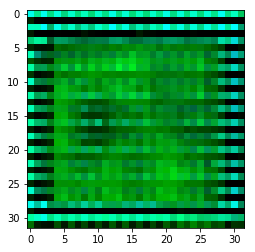

epoch = 7 , batch = 58 g_loss = [2.0143914]
epoch = 7 , batch = 158 g_loss = [1.4624722]
epoch = 7 , batch = 258 g_loss = [1.6889833]
epoch = 7 , batch = 358 g_loss = [1.7268949]
epoch = 7 , batch = 458 g_loss = [1.921265]
epoch = 7 , batch = 558 g_loss = [1.9701267]
epoch = 7 , batch = 658 g_loss = [1.9839942]
epoch = 7 , batch = 758 g_loss = [1.8354635]
epoch = 7 , batch = 858 g_loss = [2.8040416]
epoch = 7 , batch = 958 g_loss = [1.8528455]
epoch = 7 , batch = 1058 g_loss = [1.9042473]
epoch = 7 , batch = 1158 g_loss = [1.8341135]
epoch = 7 , batch = 1258 g_loss = [1.8195808]
epoch = 7 , batch = 1358 g_loss = [1.5505679]
epoch = 7 , batch = 1458 g_loss = [1.6208656]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch = 7 , batch = 1558 g_loss = [1.8265004]


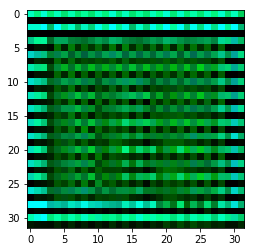

epoch = 8 , batch = 95 g_loss = [1.8833406]
epoch = 8 , batch = 195 g_loss = [1.8868968]
epoch = 8 , batch = 295 g_loss = [1.6387444]
epoch = 8 , batch = 395 g_loss = [1.7137461]
epoch = 8 , batch = 495 g_loss = [1.9392893]
epoch = 8 , batch = 595 g_loss = [1.8763717]
epoch = 8 , batch = 695 g_loss = [1.6727376]
epoch = 8 , batch = 795 g_loss = [1.7409527]
epoch = 8 , batch = 895 g_loss = [1.9037979]
epoch = 8 , batch = 995 g_loss = [1.8967724]
epoch = 8 , batch = 1095 g_loss = [1.5363183]
epoch = 8 , batch = 1195 g_loss = [1.9188629]
epoch = 8 , batch = 1295 g_loss = [1.8247647]
epoch = 8 , batch = 1395 g_loss = [2.1254148]
epoch = 8 , batch = 1495 g_loss = [1.8578941]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


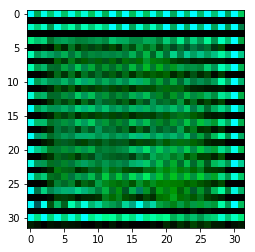

epoch = 9 , batch = 32 g_loss = [2.0842116]
epoch = 9 , batch = 132 g_loss = [2.049822]
epoch = 9 , batch = 232 g_loss = [1.6924952]
epoch = 9 , batch = 332 g_loss = [1.8629977]
epoch = 9 , batch = 432 g_loss = [2.1503632]
epoch = 9 , batch = 532 g_loss = [1.8167312]
epoch = 9 , batch = 632 g_loss = [1.5825256]
epoch = 9 , batch = 732 g_loss = [1.7960341]
epoch = 9 , batch = 832 g_loss = [1.6274841]
epoch = 9 , batch = 932 g_loss = [1.9219235]
epoch = 9 , batch = 1032 g_loss = [2.0597405]
epoch = 9 , batch = 1132 g_loss = [1.4897798]
epoch = 9 , batch = 1232 g_loss = [1.6342151]
epoch = 9 , batch = 1332 g_loss = [1.7135681]
epoch = 9 , batch = 1432 g_loss = [1.6115484]
epoch = 9 , batch = 1532 g_loss = [1.7336555]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


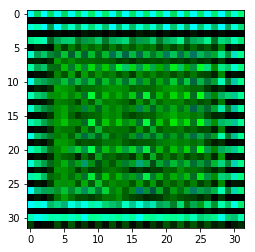

In [93]:
train(epoch_num=10, batch_size=32, use_gpu=True, load_model=False)

In [ ]:
import os, cv2
import paddle.nn.functional as F
from paddle.fluid.dygraph import to_variable, save_dygraph

def train(epoch_num=10, batch_size=128, use_gpu=True, load_model=False):
    # 使用GPU
    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()

    with fluid.dygraph.guard(place):
        # 模型存储路径
        model_path = './output_second/'

        # 分别定义转换、判别对象
        # 注意：别忘记写输出通道数
        g = UNet(3)
        g.train()
 
        # 注意：别忘记写分类数
        # 输出两部分，1：特征（特征损失） 2：分类结果（识别损失）
        d = MyNet(10)
        model_para, _ = fluid.load_dygraph("Cifar10_vgg19/no/vgg16")
        d.load_dict(model_para)
        d.eval()

        # 定义优化器对象,判别网络是预训练好的，不需要改动的。
        g_optimizer = fluid.optimizer.AdamOptimizer(learning_rate=2e-4, parameter_list=g.parameters())
   
        # 读取上次保存的模型
        if load_model == True:
            g_para, g_opt = fluid.load_dygraph(model_path+'g')
            reg_para, reg_opt = fluid.load_dygraph(model_path+'reg')
       
            g.load_dict(g_para)
            g_optimizer.set_dict(g_opt)
            reg.load_dict(reg_para)
            reg_optimizer.set_dict(reg_opt)

        iteration_num = 0
        for epoch in range(epoch_num):
            for i, data in enumerate(train_loader()):
                real_image = data[0]
                y_data = paddle.to_tensor(data[1])
                y_data = paddle.unsqueeze(y_data, 1)
                
                iteration_num += 1
                
                '''
                转换网络g：生成的图片使得判别网络g能识别，且特征损失变大。
                '''
                # 转换网络g对图片进行转换
                transform_image = g(real_image)
                # 判别网络对原始图片提取特征
                featuremap_o,_ = d(real_image)
                # 判别网络对转换的图片进行识别
                featuremap_t,pre = d(transform_image)
                # 计算识别交叉熵损失
                d_cost = F.cross_entropy(pre, y_data)

                # 特征损失变大
                # print(featuremap_o.shape)
                # print(featuremap_t.shape)
                reg_cost = F.mse_loss(featuremap_o,featuremap_t)
                # print(d_cost.numpy())
                # print(reg_cost.numpy())
                # 反向传播更新g的参数
                total_loss = d_cost - 0.005 * reg_cost
                total_loss.backward()
                g_optimizer.minimize(total_loss)
                g.clear_gradients()
                
                # 打印输出
                if(iteration_num % 100 == 0):
                    print('epoch =', epoch, ', batch =', i, 'g_loss =', total_loss.numpy())
                    # show_image_grid(fake.numpy(), BATCH_SIZE, epoch)

            for img in transform_image.numpy():
                img = img.transpose(1,2,0)
                plt.imshow(img)
                plt.show()
                break;
        # 存储模型
        fluid.save_dygraph(g.state_dict(), model_path+'g')
        fluid.save_dygraph(g_optimizer.state_dict(), model_path+'g')

epoch = 0 , batch = 99 g_loss = [7.010468]
epoch = 0 , batch = 199 g_loss = [4.8846054]
epoch = 0 , batch = 299 g_loss = [4.506072]
epoch = 0 , batch = 399 g_loss = [3.2754476]
epoch = 0 , batch = 499 g_loss = [2.3915954]
epoch = 0 , batch = 599 g_loss = [2.3483326]
epoch = 0 , batch = 699 g_loss = [2.7491136]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


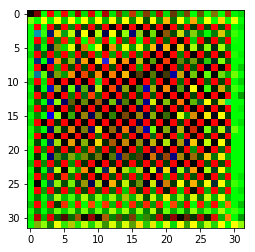

epoch = 1 , batch = 17 g_loss = [1.8647115]
epoch = 1 , batch = 117 g_loss = [1.8849334]
epoch = 1 , batch = 217 g_loss = [2.089096]
epoch = 1 , batch = 317 g_loss = [1.4928021]
epoch = 1 , batch = 417 g_loss = [1.471259]
epoch = 1 , batch = 517 g_loss = [1.8762329]
epoch = 1 , batch = 617 g_loss = [1.9645168]
epoch = 1 , batch = 717 g_loss = [1.4898154]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


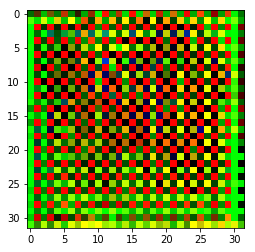

epoch = 2 , batch = 35 g_loss = [1.306022]
epoch = 2 , batch = 135 g_loss = [1.323284]
epoch = 2 , batch = 235 g_loss = [1.1244905]
epoch = 2 , batch = 335 g_loss = [1.7646521]
epoch = 2 , batch = 435 g_loss = [1.3653232]
epoch = 2 , batch = 535 g_loss = [1.4256227]
epoch = 2 , batch = 635 g_loss = [1.3957494]
epoch = 2 , batch = 735 g_loss = [1.018018]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


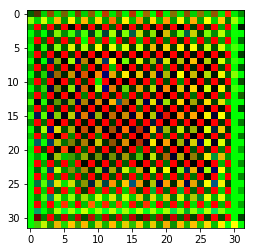

epoch = 3 , batch = 53 g_loss = [1.0974022]
epoch = 3 , batch = 153 g_loss = [1.1611427]
epoch = 3 , batch = 253 g_loss = [1.3889647]
epoch = 3 , batch = 353 g_loss = [1.0101554]
epoch = 3 , batch = 453 g_loss = [1.0545777]
epoch = 3 , batch = 553 g_loss = [1.2078996]
epoch = 3 , batch = 653 g_loss = [1.0153393]
epoch = 3 , batch = 753 g_loss = [1.5105307]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


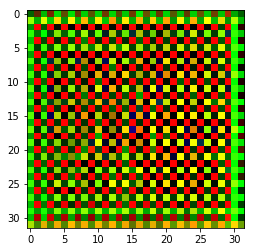

epoch = 4 , batch = 71 g_loss = [0.8703346]
epoch = 4 , batch = 171 g_loss = [0.8916211]
epoch = 4 , batch = 271 g_loss = [0.9426988]
epoch = 4 , batch = 371 g_loss = [1.0910594]
epoch = 4 , batch = 471 g_loss = [1.1616253]
epoch = 4 , batch = 571 g_loss = [0.85416824]
epoch = 4 , batch = 671 g_loss = [1.1047573]
epoch = 4 , batch = 771 g_loss = [0.9974754]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


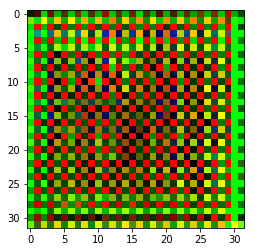

epoch = 5 , batch = 89 g_loss = [0.7371275]
epoch = 5 , batch = 189 g_loss = [0.8954619]
epoch = 5 , batch = 289 g_loss = [0.8981876]
epoch = 5 , batch = 389 g_loss = [1.1113347]
epoch = 5 , batch = 489 g_loss = [0.8727821]
epoch = 5 , batch = 589 g_loss = [0.7815642]
epoch = 5 , batch = 689 g_loss = [0.86980855]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


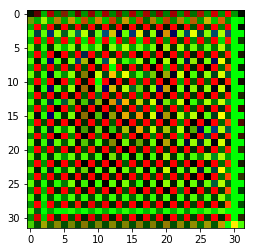

epoch = 6 , batch = 7 g_loss = [0.85470265]
epoch = 6 , batch = 107 g_loss = [0.641744]
epoch = 6 , batch = 207 g_loss = [0.8283074]
epoch = 6 , batch = 307 g_loss = [0.7265835]
epoch = 6 , batch = 407 g_loss = [0.95984024]
epoch = 6 , batch = 507 g_loss = [1.0807481]
epoch = 6 , batch = 607 g_loss = [0.92837644]
epoch = 6 , batch = 707 g_loss = [0.76559055]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


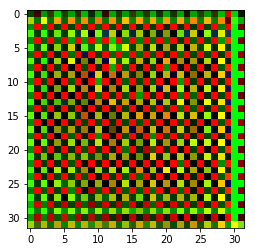

epoch = 7 , batch = 25 g_loss = [0.6265451]
epoch = 7 , batch = 125 g_loss = [0.6524858]
epoch = 7 , batch = 225 g_loss = [0.56042767]
epoch = 7 , batch = 325 g_loss = [0.5188999]
epoch = 7 , batch = 425 g_loss = [0.7860819]
epoch = 7 , batch = 525 g_loss = [0.5745146]
epoch = 7 , batch = 625 g_loss = [0.93196994]
epoch = 7 , batch = 725 g_loss = [0.5871116]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


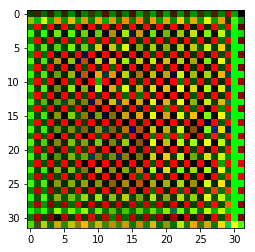

epoch = 8 , batch = 43 g_loss = [0.6053441]
epoch = 8 , batch = 143 g_loss = [0.5289318]
epoch = 8 , batch = 243 g_loss = [0.48459]
epoch = 8 , batch = 343 g_loss = [0.8054785]
epoch = 8 , batch = 443 g_loss = [0.46516493]
epoch = 8 , batch = 543 g_loss = [0.5912651]
epoch = 8 , batch = 643 g_loss = [0.70329416]
epoch = 8 , batch = 743 g_loss = [0.6081189]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


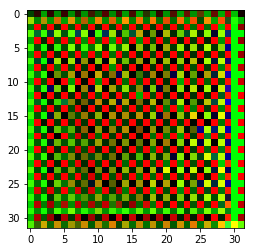

epoch = 9 , batch = 61 g_loss = [0.3846354]
epoch = 9 , batch = 161 g_loss = [0.41632947]
epoch = 9 , batch = 261 g_loss = [0.43135568]
epoch = 9 , batch = 361 g_loss = [0.37264943]
epoch = 9 , batch = 461 g_loss = [0.5661803]
epoch = 9 , batch = 561 g_loss = [0.5204933]
epoch = 9 , batch = 661 g_loss = [0.41177762]
epoch = 9 , batch = 761 g_loss = [0.36115992]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


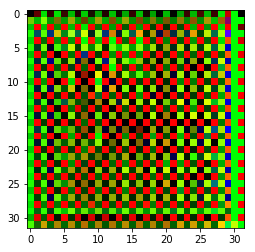

epoch = 10 , batch = 79 g_loss = [0.32792562]
epoch = 10 , batch = 179 g_loss = [0.25319916]
epoch = 10 , batch = 279 g_loss = [0.42332417]
epoch = 10 , batch = 379 g_loss = [0.35155928]
epoch = 10 , batch = 479 g_loss = [0.39510852]
epoch = 10 , batch = 579 g_loss = [0.23252775]
epoch = 10 , batch = 679 g_loss = [0.3013914]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch = 10 , batch = 779 g_loss = [0.5423286]


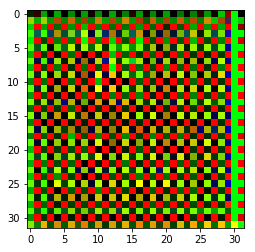

epoch = 11 , batch = 97 g_loss = [0.35584497]
epoch = 11 , batch = 197 g_loss = [0.24876325]
epoch = 11 , batch = 297 g_loss = [0.34952146]
epoch = 11 , batch = 397 g_loss = [0.5564567]
epoch = 11 , batch = 497 g_loss = [0.23643343]
epoch = 11 , batch = 597 g_loss = [0.4878233]
epoch = 11 , batch = 697 g_loss = [0.2759505]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


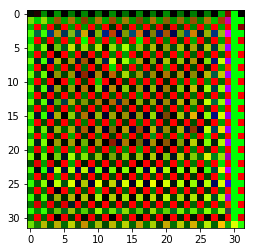

epoch = 12 , batch = 15 g_loss = [0.5093026]
epoch = 12 , batch = 115 g_loss = [0.16976435]
epoch = 12 , batch = 215 g_loss = [0.33580482]
epoch = 12 , batch = 315 g_loss = [0.38952538]
epoch = 12 , batch = 415 g_loss = [0.26758185]
epoch = 12 , batch = 515 g_loss = [0.3195687]
epoch = 12 , batch = 615 g_loss = [0.37278247]
epoch = 12 , batch = 715 g_loss = [0.2415579]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


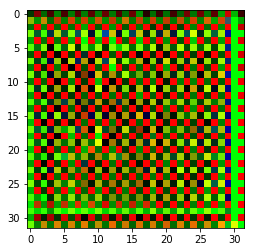

epoch = 13 , batch = 33 g_loss = [0.16269791]
epoch = 13 , batch = 133 g_loss = [0.2945218]
epoch = 13 , batch = 233 g_loss = [0.15440935]
epoch = 13 , batch = 333 g_loss = [0.29316217]
epoch = 13 , batch = 433 g_loss = [0.34673363]
epoch = 13 , batch = 533 g_loss = [0.08790384]
epoch = 13 , batch = 633 g_loss = [0.20064217]
epoch = 13 , batch = 733 g_loss = [0.3090749]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


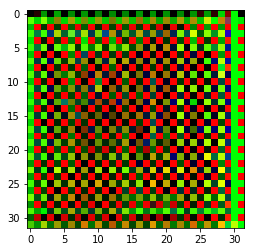

epoch = 14 , batch = 51 g_loss = [0.21034643]
epoch = 14 , batch = 151 g_loss = [0.3335282]
epoch = 14 , batch = 251 g_loss = [0.10101315]
epoch = 14 , batch = 351 g_loss = [0.16833968]
epoch = 14 , batch = 451 g_loss = [0.10662037]
epoch = 14 , batch = 551 g_loss = [0.19788697]
epoch = 14 , batch = 651 g_loss = [0.283329]
epoch = 14 , batch = 751 g_loss = [0.13069823]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


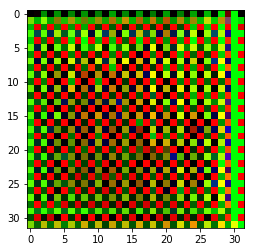

epoch = 15 , batch = 69 g_loss = [0.07027017]
epoch = 15 , batch = 169 g_loss = [0.0905913]
epoch = 15 , batch = 269 g_loss = [0.19722609]
epoch = 15 , batch = 369 g_loss = [0.29537842]
epoch = 15 , batch = 469 g_loss = [0.11113221]
epoch = 15 , batch = 569 g_loss = [0.19214734]
epoch = 15 , batch = 669 g_loss = [0.23357072]
epoch = 15 , batch = 769 g_loss = [0.11001258]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


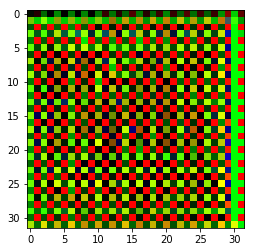

epoch = 16 , batch = 87 g_loss = [0.09908263]
epoch = 16 , batch = 187 g_loss = [0.10373716]
epoch = 16 , batch = 287 g_loss = [0.14670157]
epoch = 16 , batch = 387 g_loss = [0.18758047]
epoch = 16 , batch = 487 g_loss = [0.081246]
epoch = 16 , batch = 587 g_loss = [0.08564118]
epoch = 16 , batch = 687 g_loss = [0.07429766]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


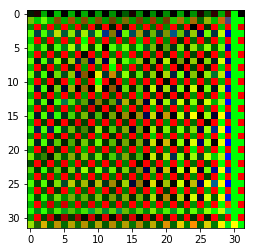

epoch = 17 , batch = 5 g_loss = [0.19037688]
epoch = 17 , batch = 105 g_loss = [0.07786909]
epoch = 17 , batch = 205 g_loss = [0.05367523]
epoch = 17 , batch = 305 g_loss = [0.26530778]
epoch = 17 , batch = 405 g_loss = [0.10751474]
epoch = 17 , batch = 505 g_loss = [0.17386565]
epoch = 17 , batch = 605 g_loss = [0.35736364]
epoch = 17 , batch = 705 g_loss = [0.21148859]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


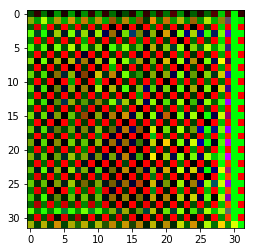

epoch = 18 , batch = 23 g_loss = [0.06518309]
epoch = 18 , batch = 123 g_loss = [0.02029375]
epoch = 18 , batch = 223 g_loss = [0.10254862]
epoch = 18 , batch = 323 g_loss = [0.04429702]
epoch = 18 , batch = 423 g_loss = [0.0140032]
epoch = 18 , batch = 523 g_loss = [0.16841443]
epoch = 18 , batch = 623 g_loss = [0.05090696]
epoch = 18 , batch = 723 g_loss = [0.15453766]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


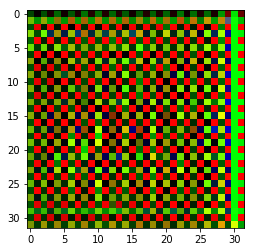

epoch = 19 , batch = 41 g_loss = [0.13749598]
epoch = 19 , batch = 141 g_loss = [0.01746294]
epoch = 19 , batch = 241 g_loss = [0.075134]
epoch = 19 , batch = 341 g_loss = [0.07712813]
epoch = 19 , batch = 441 g_loss = [0.05912545]
epoch = 19 , batch = 541 g_loss = [0.13740698]
epoch = 19 , batch = 641 g_loss = [0.07423998]
epoch = 19 , batch = 741 g_loss = [0.12451113]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


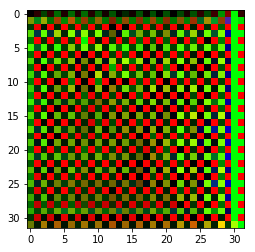

epoch = 20 , batch = 59 g_loss = [0.08515011]
epoch = 20 , batch = 159 g_loss = [0.02805525]
epoch = 20 , batch = 259 g_loss = [0.1244555]
epoch = 20 , batch = 359 g_loss = [0.07155932]
epoch = 20 , batch = 459 g_loss = [0.2549539]
epoch = 20 , batch = 559 g_loss = [0.17191462]
epoch = 20 , batch = 659 g_loss = [0.17723171]
epoch = 20 , batch = 759 g_loss = [0.00744314]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


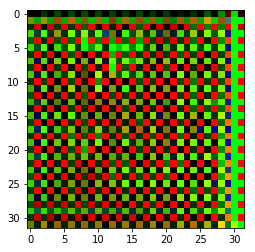

epoch = 21 , batch = 77 g_loss = [0.0506342]
epoch = 21 , batch = 177 g_loss = [0.01228209]
epoch = 21 , batch = 277 g_loss = [0.14297344]
epoch = 21 , batch = 377 g_loss = [0.05313558]
epoch = 21 , batch = 477 g_loss = [0.197903]
epoch = 21 , batch = 577 g_loss = [0.11531242]
epoch = 21 , batch = 677 g_loss = [0.19133891]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch = 21 , batch = 777 g_loss = [0.08306128]


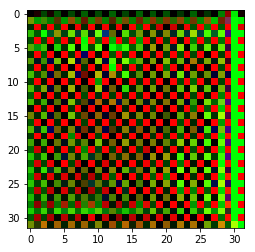

epoch = 22 , batch = 95 g_loss = [0.07021241]
epoch = 22 , batch = 195 g_loss = [0.03055309]
epoch = 22 , batch = 295 g_loss = [0.11081839]
epoch = 22 , batch = 395 g_loss = [0.27203742]
epoch = 22 , batch = 495 g_loss = [0.24642482]
epoch = 22 , batch = 595 g_loss = [0.13752224]
epoch = 22 , batch = 695 g_loss = [0.31412417]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


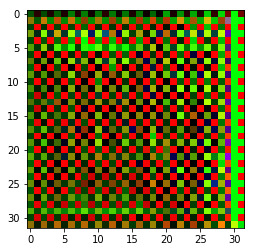

epoch = 23 , batch = 13 g_loss = [0.06424772]
epoch = 23 , batch = 113 g_loss = [0.03599709]
epoch = 23 , batch = 213 g_loss = [0.02511575]
epoch = 23 , batch = 313 g_loss = [0.22077116]
epoch = 23 , batch = 413 g_loss = [0.07888859]
epoch = 23 , batch = 513 g_loss = [0.1110978]
epoch = 23 , batch = 613 g_loss = [0.0439462]
epoch = 23 , batch = 713 g_loss = [0.22553405]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


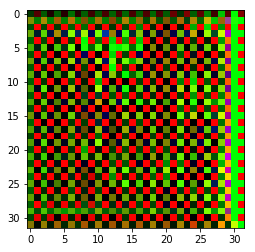

epoch = 24 , batch = 31 g_loss = [0.20076375]
epoch = 24 , batch = 131 g_loss = [0.08002248]
epoch = 24 , batch = 231 g_loss = [0.07749296]
epoch = 24 , batch = 331 g_loss = [0.0375709]
epoch = 24 , batch = 431 g_loss = [0.05636583]
epoch = 24 , batch = 531 g_loss = [0.01947003]
epoch = 24 , batch = 631 g_loss = [0.08644933]
epoch = 24 , batch = 731 g_loss = [0.1359335]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


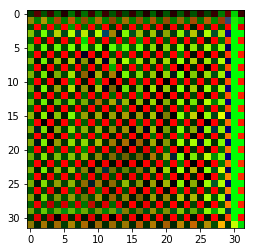

epoch = 25 , batch = 49 g_loss = [0.01609224]
epoch = 25 , batch = 149 g_loss = [0.12673473]
epoch = 25 , batch = 249 g_loss = [0.12426899]
epoch = 25 , batch = 349 g_loss = [0.03477457]
epoch = 25 , batch = 449 g_loss = [0.0077382]
epoch = 25 , batch = 549 g_loss = [0.06505802]
epoch = 25 , batch = 649 g_loss = [0.09656636]
epoch = 25 , batch = 749 g_loss = [0.24278384]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


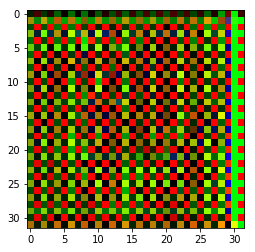

epoch = 26 , batch = 67 g_loss = [0.117966]
epoch = 26 , batch = 167 g_loss = [0.06096717]
epoch = 26 , batch = 267 g_loss = [0.03564997]
epoch = 26 , batch = 367 g_loss = [0.0462774]
epoch = 26 , batch = 467 g_loss = [0.25880098]
epoch = 26 , batch = 567 g_loss = [0.06254961]
epoch = 26 , batch = 667 g_loss = [0.08315323]
epoch = 26 , batch = 767 g_loss = [0.07898619]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


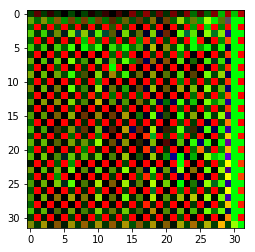

epoch = 27 , batch = 85 g_loss = [0.00374793]
epoch = 27 , batch = 185 g_loss = [0.05698337]
epoch = 27 , batch = 285 g_loss = [0.08158471]
epoch = 27 , batch = 385 g_loss = [0.14768755]
epoch = 27 , batch = 485 g_loss = [0.04388587]
epoch = 27 , batch = 585 g_loss = [0.07604182]
epoch = 27 , batch = 685 g_loss = [0.05618735]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


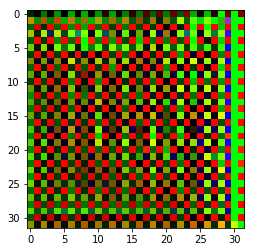

epoch = 28 , batch = 3 g_loss = [0.02646919]
epoch = 28 , batch = 103 g_loss = [0.10566141]
epoch = 28 , batch = 203 g_loss = [0.06514374]
epoch = 28 , batch = 303 g_loss = [0.21580762]
epoch = 28 , batch = 403 g_loss = [0.06606138]
epoch = 28 , batch = 503 g_loss = [0.01339111]
epoch = 28 , batch = 603 g_loss = [0.0371114]
epoch = 28 , batch = 703 g_loss = [0.0427249]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


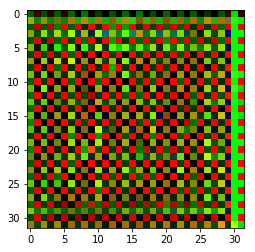

epoch = 29 , batch = 21 g_loss = [-8.84193e-05]
epoch = 29 , batch = 121 g_loss = [0.0257699]
epoch = 29 , batch = 221 g_loss = [0.22776978]
epoch = 29 , batch = 321 g_loss = [0.00626426]
epoch = 29 , batch = 421 g_loss = [0.04110951]
epoch = 29 , batch = 521 g_loss = [0.04995487]
epoch = 29 , batch = 621 g_loss = [0.02051129]
epoch = 29 , batch = 721 g_loss = [0.00166257]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


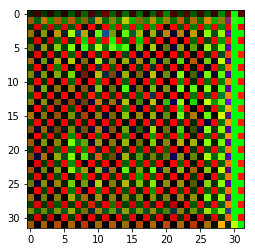

epoch = 30 , batch = 39 g_loss = [0.00169362]
epoch = 30 , batch = 139 g_loss = [0.01844466]
epoch = 30 , batch = 239 g_loss = [0.01870976]
epoch = 30 , batch = 339 g_loss = [0.08082128]
epoch = 30 , batch = 439 g_loss = [0.05228982]
epoch = 30 , batch = 539 g_loss = [0.11283363]
epoch = 30 , batch = 639 g_loss = [0.02413163]
epoch = 30 , batch = 739 g_loss = [0.15547968]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


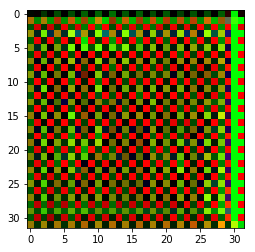

epoch = 31 , batch = 57 g_loss = [0.05755278]
epoch = 31 , batch = 157 g_loss = [0.0273592]
epoch = 31 , batch = 257 g_loss = [0.00400849]
epoch = 31 , batch = 357 g_loss = [0.07331182]
epoch = 31 , batch = 457 g_loss = [0.03572761]
epoch = 31 , batch = 557 g_loss = [0.01610778]
epoch = 31 , batch = 657 g_loss = [0.05100318]
epoch = 31 , batch = 757 g_loss = [0.07262284]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


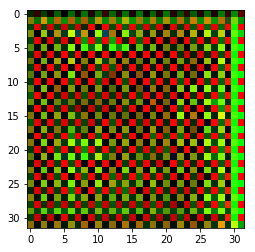

epoch = 32 , batch = 75 g_loss = [0.03341022]
epoch = 32 , batch = 175 g_loss = [0.0492195]
epoch = 32 , batch = 275 g_loss = [0.08900061]
epoch = 32 , batch = 375 g_loss = [0.04217433]
epoch = 32 , batch = 475 g_loss = [0.20862322]
epoch = 32 , batch = 575 g_loss = [0.0623004]
epoch = 32 , batch = 675 g_loss = [0.07056444]
epoch = 32 , batch = 775 g_loss = [0.0346868]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


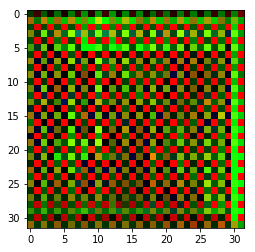

epoch = 33 , batch = 93 g_loss = [0.01526769]
epoch = 33 , batch = 193 g_loss = [0.01899308]
epoch = 33 , batch = 293 g_loss = [0.00243203]
epoch = 33 , batch = 393 g_loss = [0.01658812]
epoch = 33 , batch = 493 g_loss = [0.00409167]
epoch = 33 , batch = 593 g_loss = [0.01608701]
epoch = 33 , batch = 693 g_loss = [0.00907576]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


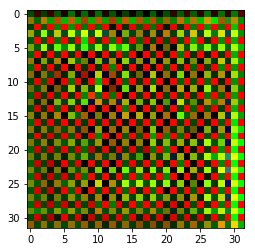

epoch = 34 , batch = 11 g_loss = [0.01610204]
epoch = 34 , batch = 111 g_loss = [0.0353755]
epoch = 34 , batch = 211 g_loss = [0.01004643]
epoch = 34 , batch = 311 g_loss = [0.01883027]
epoch = 34 , batch = 411 g_loss = [0.02583774]
epoch = 34 , batch = 511 g_loss = [0.090156]
epoch = 34 , batch = 611 g_loss = [0.11740224]
epoch = 34 , batch = 711 g_loss = [0.01469731]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


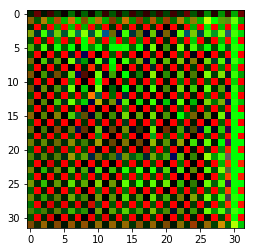

epoch = 35 , batch = 29 g_loss = [-0.00141248]
epoch = 35 , batch = 129 g_loss = [0.00894644]
epoch = 35 , batch = 229 g_loss = [0.02935746]
epoch = 35 , batch = 329 g_loss = [0.03203287]
epoch = 35 , batch = 429 g_loss = [0.00246686]
epoch = 35 , batch = 529 g_loss = [0.02374399]
epoch = 35 , batch = 629 g_loss = [0.09314823]
epoch = 35 , batch = 729 g_loss = [0.0195583]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


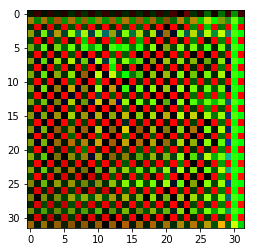

epoch = 36 , batch = 47 g_loss = [0.00047219]
epoch = 36 , batch = 147 g_loss = [0.03603491]
epoch = 36 , batch = 247 g_loss = [0.01704655]
epoch = 36 , batch = 347 g_loss = [0.04811836]
epoch = 36 , batch = 447 g_loss = [0.05134009]
epoch = 36 , batch = 547 g_loss = [0.0675775]
epoch = 36 , batch = 647 g_loss = [0.01033529]
epoch = 36 , batch = 747 g_loss = [0.00698392]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


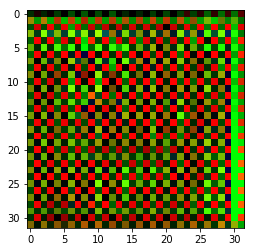

epoch = 37 , batch = 65 g_loss = [0.06574233]
epoch = 37 , batch = 165 g_loss = [0.02656712]
epoch = 37 , batch = 265 g_loss = [0.0310632]
epoch = 37 , batch = 365 g_loss = [0.00657102]
epoch = 37 , batch = 465 g_loss = [0.04924068]
epoch = 37 , batch = 565 g_loss = [0.00300029]
epoch = 37 , batch = 665 g_loss = [0.06050844]
epoch = 37 , batch = 765 g_loss = [0.03256759]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


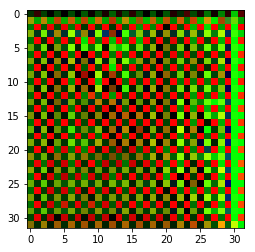

epoch = 38 , batch = 83 g_loss = [0.01905011]
epoch = 38 , batch = 183 g_loss = [0.02606153]
epoch = 38 , batch = 283 g_loss = [0.22761999]
epoch = 38 , batch = 383 g_loss = [-0.00023201]
epoch = 38 , batch = 483 g_loss = [0.11838435]
epoch = 38 , batch = 583 g_loss = [0.04906274]
epoch = 38 , batch = 683 g_loss = [0.16844966]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


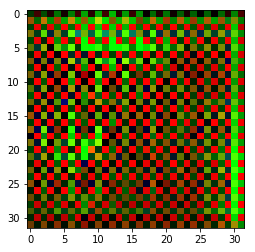

epoch = 39 , batch = 1 g_loss = [0.05704915]
epoch = 39 , batch = 101 g_loss = [0.02004991]
epoch = 39 , batch = 201 g_loss = [0.01247154]
epoch = 39 , batch = 301 g_loss = [0.0133138]
epoch = 39 , batch = 401 g_loss = [0.01199293]
epoch = 39 , batch = 501 g_loss = [0.01962283]
epoch = 39 , batch = 601 g_loss = [0.04872006]
epoch = 39 , batch = 701 g_loss = [0.15560058]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


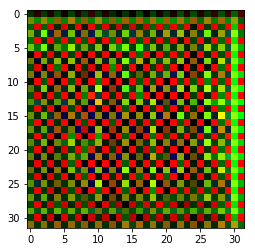

epoch = 40 , batch = 19 g_loss = [0.01709798]
epoch = 40 , batch = 119 g_loss = [0.02355677]
epoch = 40 , batch = 219 g_loss = [0.00961423]
epoch = 40 , batch = 319 g_loss = [0.04499135]
epoch = 40 , batch = 419 g_loss = [0.01490447]
epoch = 40 , batch = 519 g_loss = [0.02623241]
epoch = 40 , batch = 619 g_loss = [0.04429208]
epoch = 40 , batch = 719 g_loss = [0.1339826]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


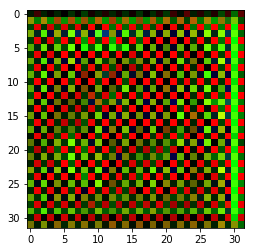

epoch = 41 , batch = 37 g_loss = [0.11363446]
epoch = 41 , batch = 137 g_loss = [0.02420163]
epoch = 41 , batch = 237 g_loss = [-0.00147971]
epoch = 41 , batch = 337 g_loss = [0.01050108]
epoch = 41 , batch = 437 g_loss = [0.14886092]
epoch = 41 , batch = 537 g_loss = [-0.00253335]
epoch = 41 , batch = 637 g_loss = [0.01308981]
epoch = 41 , batch = 737 g_loss = [0.04342628]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


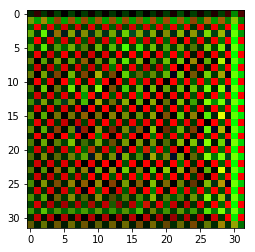

epoch = 42 , batch = 55 g_loss = [0.01355811]
epoch = 42 , batch = 155 g_loss = [-0.00061584]
epoch = 42 , batch = 255 g_loss = [0.06794816]
epoch = 42 , batch = 355 g_loss = [0.0870779]
epoch = 42 , batch = 455 g_loss = [0.05611657]
epoch = 42 , batch = 555 g_loss = [0.06883065]
epoch = 42 , batch = 655 g_loss = [0.00890282]
epoch = 42 , batch = 755 g_loss = [-0.00185971]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


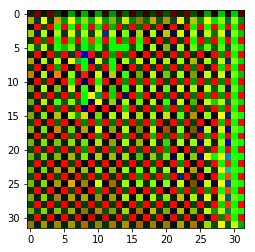

epoch = 43 , batch = 73 g_loss = [0.02571483]
epoch = 43 , batch = 173 g_loss = [0.08356214]
epoch = 43 , batch = 273 g_loss = [0.04521637]
epoch = 43 , batch = 373 g_loss = [0.01596806]
epoch = 43 , batch = 473 g_loss = [0.03512879]
epoch = 43 , batch = 573 g_loss = [0.01024946]
epoch = 43 , batch = 673 g_loss = [0.00769611]
epoch = 43 , batch = 773 g_loss = [0.00818225]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


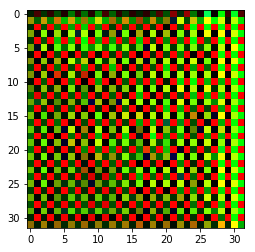

epoch = 44 , batch = 91 g_loss = [-0.00203776]
epoch = 44 , batch = 191 g_loss = [0.00189263]
epoch = 44 , batch = 291 g_loss = [-0.00267492]
epoch = 44 , batch = 391 g_loss = [0.04586194]
epoch = 44 , batch = 491 g_loss = [0.04106044]
epoch = 44 , batch = 591 g_loss = [0.09529225]
epoch = 44 , batch = 691 g_loss = [0.02924657]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


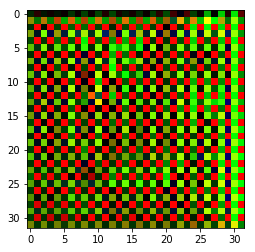

epoch = 45 , batch = 9 g_loss = [0.00403379]
epoch = 45 , batch = 109 g_loss = [0.05713093]
epoch = 45 , batch = 209 g_loss = [0.05668565]
epoch = 45 , batch = 309 g_loss = [0.0825924]
epoch = 45 , batch = 409 g_loss = [-0.00340219]
epoch = 45 , batch = 509 g_loss = [-0.00380666]
epoch = 45 , batch = 609 g_loss = [0.00728431]
epoch = 45 , batch = 709 g_loss = [0.03877388]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


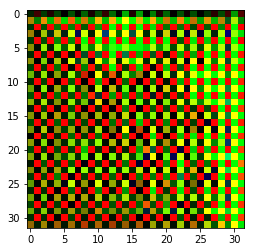

epoch = 46 , batch = 27 g_loss = [0.00023415]
epoch = 46 , batch = 127 g_loss = [-0.00366857]
epoch = 46 , batch = 227 g_loss = [0.02470581]
epoch = 46 , batch = 327 g_loss = [-0.00154244]
epoch = 46 , batch = 427 g_loss = [0.00049614]
epoch = 46 , batch = 527 g_loss = [0.07075472]
epoch = 46 , batch = 627 g_loss = [-0.00034806]
epoch = 46 , batch = 727 g_loss = [-0.00826193]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


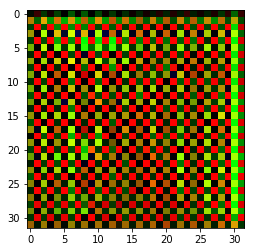

epoch = 47 , batch = 45 g_loss = [-0.01572183]
epoch = 47 , batch = 145 g_loss = [0.020135]
epoch = 47 , batch = 245 g_loss = [-0.00593788]
epoch = 47 , batch = 345 g_loss = [0.04565476]
epoch = 47 , batch = 445 g_loss = [0.05024619]
epoch = 47 , batch = 545 g_loss = [-0.01498555]
epoch = 47 , batch = 645 g_loss = [-0.02071078]
epoch = 47 , batch = 745 g_loss = [0.00038197]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


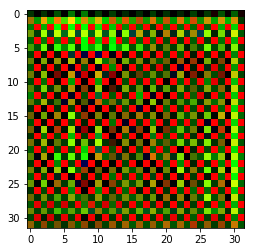

epoch = 48 , batch = 63 g_loss = [-0.0306197]
epoch = 48 , batch = 163 g_loss = [0.0611955]
epoch = 48 , batch = 263 g_loss = [0.05356256]
epoch = 48 , batch = 363 g_loss = [0.03403015]
epoch = 48 , batch = 463 g_loss = [0.3041743]
epoch = 48 , batch = 563 g_loss = [0.01093719]
epoch = 48 , batch = 663 g_loss = [0.12377663]
epoch = 48 , batch = 763 g_loss = [0.0571524]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


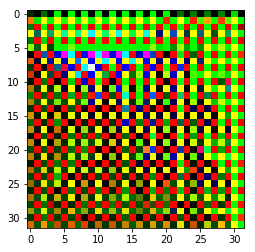

epoch = 49 , batch = 81 g_loss = [-0.06728776]
epoch = 49 , batch = 181 g_loss = [-0.04670545]
epoch = 49 , batch = 281 g_loss = [-0.06506146]
epoch = 49 , batch = 381 g_loss = [0.5212219]
epoch = 49 , batch = 481 g_loss = [0.5498552]
epoch = 49 , batch = 581 g_loss = [0.23490316]
epoch = 49 , batch = 681 g_loss = [0.15978153]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch = 49 , batch = 781 g_loss = [0.08216298]


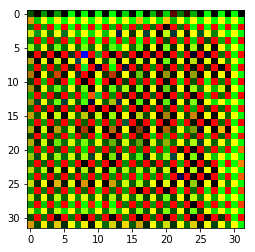

In [ ]:
train(epoch_num=50, batch_size=64, use_gpu=True, load_model=False)

### 测试转换效果

In [ ]:
import numpy as np

# 转换器
g = UNet(3)
model_para, _ = fluid.load_dygraph("output_second/g")
g.load_dict(model_para)

# 识别器
d = MyNet(10)
model_para, _ = fluid.load_dygraph("Cifar10_vgg19/no/vgg16")
d.load_dict(model_para)

for batch_id, data in enumerate(test_loader()):
    x_data = data[0]
    y_data = data[1]

    g_image = g(x_data)

    _,re_pre = d(g_image)
    _,pre = d(x_data)

    image_grid(x_data.numpy().transpose(0,2,3,1)[0],1,2,1)
    image_grid(g_image.numpy().transpose(0,2,3,1)[0],1,2,2)
  
    plt.show()
    break

y_data = y_data.numpy()
count1 = 0
count2 = 0
for i in range(64):
    print("r->d->red:{}-{}-{}".format(y_data[i],np.argmax(pre[i]),np.argmax(re_pre[i])))
    if np.argmax(pre[i]) == y_data[i]:
        count1 += 1
    if np.argmax(re_pre[i]) == y_data[i]:
        count2 += 1
print("转换前识别的准确个数为{}，准确率为{}".format(count1,count1 / 64))
print("============================")
print("转换后识别的准确个数为{}，准确率为{}".format(count2,count2 / 64))

NameError: name 'MyNet' is not defined

In [ ]:
import numpy as np

# 转换器
g = UNet(3)
model_para, _ = fluid.load_dygraph("output_second/g")
g.load_dict(model_para)

# 识别器
# d = MyNet(10)
# model_para, _ = fluid.load_dygraph("Cifar10_vgg19/no/vgg16")

d = VGG19(vgg19(num_classes = 10))
model_para, _ = fluid.load_dygraph("Cifar10_vgg19/no/vgg19")

d.load_dict(model_para)

acc = []
reacc = []
for batch_id, data in enumerate(test_loader()):
    x_data = data[0]
    y_data = paddle.to_tensor(data[1])
    y_data = paddle.unsqueeze(y_data, 1)
    
    g_image = g(x_data)

    pre = d(x_data)
    re_pre = d(g_image)

    acc.append(paddle.metric.accuracy(pre, y_data).numpy())
    reacc.append(paddle.metric.accuracy(re_pre, y_data).numpy())

print(np.mean(acc))
print(np.mean(reacc))

0.5946457
0.618332


# 试图恢复图像

## 攻击训练

In [ ]:
import os, cv2
import numpy as np

import paddle.nn.functional as F
from paddle.fluid.dygraph import to_variable, save_dygraph

def attack_train(epoch_num = 1000, use_gpu = True,load_model = True,dataSet="MNIST",meath="Mosaic",attack_model="MLP"):

    # 使用GPU
    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()

    with fluid.dygraph.guard(place):
        # 实例化重构网络
        if attack_model=="myObfuscator":
            attack = myObfuscator()
        elif attack_model=="SRResnet":
            attack = SRResnet(64,64)
        elif attack_model=="Obfuscator":
            attack = Obfuscator()
        elif attack_model=="UNet":
            attack = UNet(3)
        else:
            attack = myObfuscatorAndUNet(0.4,0.6)
        
        # 用于得到转换图片
        if meath == "firstpaper":
            g = Obfuscator()
            model_para, _ = fluid.load_dygraph("output2/g")
            g.load_dict(model_para)
            g.eval()
        elif meath == "secondpaper":
            g = UNet(3)
            model_para, _ = fluid.load_dygraph("output_second/g")
        
        d = MyVGG16()
        model_para, _ = fluid.load_dygraph("Cifar10_vgg16/no/vgg16")
        d.load_dict(model_para)
        d.eval()

        # 配置优化器
        scheduler = paddle.optimizer.lr.ExponentialDecay(learning_rate=0.001, gamma=0.1, verbose=True)
        opt = paddle.optimizer.Momentum(learning_rate=scheduler,parameters=attack.parameters())
        
        # 多级目录
        savePath = os.path.join(dataSet+"_"+attack_model,meath)
        if load_model and os.path.exists(savePath):
            model_para, model_opt = fluid.load_dygraph("Cifar10_merge/retrain/merge")
            # model_para, model_opt = fluid.load_dygraph(savePath + '/'+attack_model)
            attack.load_dict(model_para)
            # opt.set_dict(model_opt)
        
        if not os.path.exists(savePath):
            os.makedirs(savePath)

        # 模型训练
        attack.train()
        print('Start training...')
        for epoch in range(epoch_num):
            for batch_id, data in enumerate(train_loader()):
                # x_data包括批量原始图片和转换过的图片
                x_data = data[0]
                # 一个批量的标签
                y_data =data[1]

                re_image = attack(g(x_data))

                feature_o = d(x_data,True)

                feature_r = d(re_image,True)

                loss = F.mse_loss(feature_r,feature_o)

                avg_loss = F.mse_loss(re_image, x_data)
   
                if batch_id % 500 == 0:
                    print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))
                
                total_loss = 0.5*avg_loss + 0.5*loss
                total_loss.backward()
                opt.step()
                opt.clear_grad()

            if (epoch+1) % 10 ==0:
                scheduler.step()
                save_dygraph(attack.state_dict(),os.path.join(savePath,attack_model))
                # save_dygraph(opt.state_dict(),os.path.join(savePath,attack_model))

            # 模型验证
            attack.eval()
            for batch_id, data in enumerate(test_loader()):
                x_data = data[0]
                y_data = data[1]
                
                re_image = attack(g(x_data))
                # print(re_image.shape)
                
                image_grid(x_data.numpy().transpose(0,2,3,1)[0],1,3,1)
                image_grid(g_image.numpy().transpose(0,2,3,1)[0],1,3,2)
                image_grid(re_image.numpy().transpose(0,2,3,1)[0],1,3,3)
                plt.show()

                break

            attack.train()
        
        # 模型保存
        # save_dygraph(opt.state_dict(), os.path.join(savePath,attack_model))
        save_dygraph(attack.state_dict(),os.path.join(savePath,attack_model))
        
# train(epoch_num=30,load_model=False,dataSet="Cifar10",meath="firstpaper",modelName="myObfuscator")
# train(epoch_num=30,load_model=False,dataSet="Cifar10",meath="firstpaper",modelName="Obfuscator")
# train(epoch_num=30,load_model=False,dataSet="Cifar10",meath="firstpaper",modelName="SRResnet")

## 第一篇论文的训练

In [ ]:
attack_train(epoch_num=41,load_model=True,dataSet="Cifar10",meath="firstpaper",attack_model="merge")

## 第二篇论文的训练

Start training...
epoch: 0, batch_id: 0, loss is: [0.32936275]
epoch: 0, batch_id: 100, loss is: [0.04082684]
epoch: 0, batch_id: 200, loss is: [0.0279575]
epoch: 0, batch_id: 300, loss is: [0.02387739]
epoch: 0, batch_id: 400, loss is: [0.01938256]
epoch: 0, batch_id: 500, loss is: [0.01882525]
epoch: 0, batch_id: 600, loss is: [0.01575651]
epoch: 0, batch_id: 700, loss is: [0.01554311]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


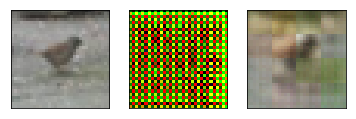

epoch: 1, batch_id: 0, loss is: [0.0141167]
epoch: 1, batch_id: 100, loss is: [0.0141779]
epoch: 1, batch_id: 200, loss is: [0.01255851]
epoch: 1, batch_id: 300, loss is: [0.01127843]
epoch: 1, batch_id: 400, loss is: [0.01042901]
epoch: 1, batch_id: 500, loss is: [0.01120672]
epoch: 1, batch_id: 600, loss is: [0.01345634]
epoch: 1, batch_id: 700, loss is: [0.01090473]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


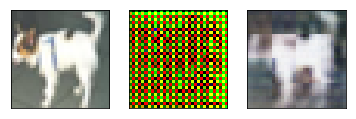

In [ ]:
train(epoch_num=2,load_model=False,dataSet="Cifar10",meath="secondpaper",modelName="myObfuscator")

Start training...
epoch: 0, batch_id: 0, loss is: [0.33138016]
epoch: 0, batch_id: 100, loss is: [0.03403342]
epoch: 0, batch_id: 200, loss is: [0.02767006]
epoch: 0, batch_id: 300, loss is: [0.02581361]
epoch: 0, batch_id: 400, loss is: [0.02347916]
epoch: 0, batch_id: 500, loss is: [0.02392679]
epoch: 0, batch_id: 600, loss is: [0.02285163]
epoch: 0, batch_id: 700, loss is: [0.01958827]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


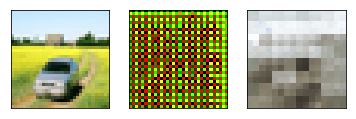

epoch: 1, batch_id: 0, loss is: [0.02002954]
epoch: 1, batch_id: 100, loss is: [0.02044047]
epoch: 1, batch_id: 200, loss is: [0.01865916]
epoch: 1, batch_id: 300, loss is: [0.01736585]
epoch: 1, batch_id: 400, loss is: [0.02069293]
epoch: 1, batch_id: 500, loss is: [0.01798821]
epoch: 1, batch_id: 600, loss is: [0.01665473]
epoch: 1, batch_id: 700, loss is: [0.01764641]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


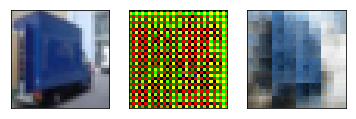

In [ ]:
train(epoch_num=2,load_model=False,dataSet="Cifar10",meath="secondpaper",modelName="Obfuscator")

Start training...
epoch: 0, batch_id: 0, loss is: [1.0376751]
epoch: 0, batch_id: 100, loss is: [0.06554377]
epoch: 0, batch_id: 200, loss is: [0.0711816]
epoch: 0, batch_id: 300, loss is: [0.05334015]
epoch: 0, batch_id: 400, loss is: [0.03325072]
epoch: 0, batch_id: 500, loss is: [0.03109737]
epoch: 0, batch_id: 600, loss is: [0.03186331]
epoch: 0, batch_id: 700, loss is: [0.02748324]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


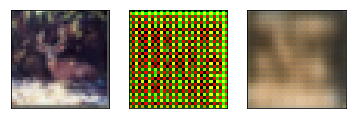

epoch: 1, batch_id: 0, loss is: [0.02059554]
epoch: 1, batch_id: 100, loss is: [0.01967518]
epoch: 1, batch_id: 200, loss is: [0.02183738]
epoch: 1, batch_id: 300, loss is: [0.01639103]
epoch: 1, batch_id: 400, loss is: [0.01618582]
epoch: 1, batch_id: 500, loss is: [0.01454546]
epoch: 1, batch_id: 600, loss is: [0.01453245]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


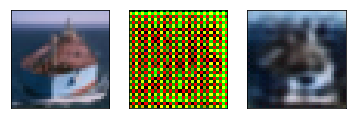

In [ ]:
train(epoch_num=2,load_model=False,dataSet="Cifar10",meath="secondpaper",modelName="UNet")

# 测试攻击模型

In [ ]:
def test_attack(g_model="",g_path="",d_model = "MyNet",d_path="Cifar10_vgg19/no/vgg16"):
    if g_model == "UNet":
        g = UNet(3)
    elif g_model == "myObfuscator":
        g = myObfuscator()
    elif g_model == "Obfuscator":
        g = Obfuscator()
    # 加载转换器
    model_para, _ = fluid.load_dygraph(g_path)
    g.load_dict(model_para)
    g.eval()
    
    if d_model == "MyNet":
        d = MyNet(10)
    elif d_model == "vgg16":
        d = MyVGG16()
        model_para, _ = fluid.load_dygraph("Cifar10_vgg16/no/vgg16")
        d.load_dict(model_para)
        d.eval()

    attack1 = myObfuscator()
    model_para, _ = fluid.load_dygraph("Cifar10_myObfuscator/firstpaper/myObfuscator")
    attack1.load_dict(model_para)
    
    attack2 = UNet(3)
    model_para, _ = fluid.load_dygraph("Cifar10_UNet/firstpaper/UNet")
    attack2.load_dict(model_para)

    attack3 = myObfuscatorAndUNet(0.4,0.6)
    # model_para, _ = fluid.load_dygraph("Cifar10_merge/retrain/merge")
    model_para, _ = fluid.load_dygraph("Cifar10_merge/firstpaper/merge")
    attack3.load_dict(model_para)

    attack1.eval()
    attack2.eval()
    attack3.eval()
    
    acc = []
    acc1 = []
    acc2 = []
    acc3 = []
    pnr1 = []
    pnr2 = []
    pnr3 = []
    for batch_id, data in enumerate(test_loader()):
        x_data = data[0]
        y_data = paddle.to_tensor(data[1])
        y_data = paddle.unsqueeze(y_data, 1)

        g_img = g(x_data)

        re_img1 = attack1(g_img)
        re_img2 = attack2(g_img)
        re_img3 = attack3(g_img)

        _,pre = d(x_data)
        _,re_pre = d(g_img)
        _,pre1 = d(re_img1)
        _,pre2 = d(re_img2)
        _,pre3 = d(re_img3)

        acc.append(paddle.metric.accuracy(re_pre,y_data).numpy())

        acc1.append(paddle.metric.accuracy(pre1,y_data).numpy())
        acc2.append(paddle.metric.accuracy(pre2,y_data).numpy())
        acc3.append(paddle.metric.accuracy(pre3,y_data).numpy())

        pnr1.append(get_psnr3(x_data.numpy(),re_img1.numpy()))
        pnr2.append(get_psnr3(x_data.numpy(),re_img2.numpy()))
        pnr3.append(get_psnr3(x_data.numpy(),re_img3.numpy()))

    print("acc = " + str(np.mean(acc)))
    
    print("acc1: {}, acc2: {}, acc3: {}".format(np.mean(acc1), np.mean(acc2), np.mean(acc3)))
    print("pnr1: {}, pnr2: {}, pnr3: {}".format(np.mean(pnr1), np.mean(pnr2), np.mean(pnr3)))


In [ ]:
test_attack(g_model="Obfuscator",g_path="output2/g",d_model = "vgg16")

acc = 0.6976837
acc1: 0.22903354465961456, acc2: 0.26587459444999695, acc3: 0.43720048666000366
pnr1: 15.164788079746765, pnr2: 16.268499306372544, pnr3: 16.28002245367649


In [1]:
def loadImg():
    images = []
    for lable in range(10):
        for i in range(2):
            tep =  np.zeros((3,32,32))#创建一个三维的数组
            for k in range(3):
                tep[k,:,:] = np.loadtxt("imgtxt/class"+str(lable)+"_"+str(i)+str(k)+".txt",dtype="float",delimiter=" ")
            # plt.imshow(tep.transpose(1,2,0))
            # plt.show()
            images.append(tep)
    return np.array(images).reshape(-1,3,32,32).transpose(0,2,3,1)

aaaaa
<class 'numpy.ndarray'>
(20, 32, 32, 3)


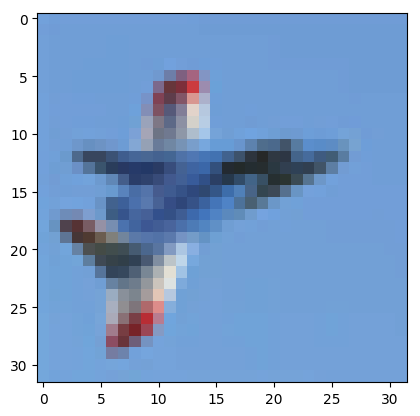

In [5]:
import paddle # 导入paddle库
import paddle.fluid as fluid
import numpy as np
from util import *

echo("aaaaa")

images = loadImg()

plt.imshow(images[0])
plt.show()
print(type(images))
print(images.shape)

In [34]:
def test_attack(g_model="",g_path="",d_model = "MyNet",d_path="Cifar10_vgg19/no/vgg16"):
    if g_model == "UNet":
        g = UNet(3)
    elif g_model == "myObfuscator":
        g = myObfuscator()
    elif g_model == "Obfuscator":
        g = Obfuscator()
    # 加载转换器
    model_para, _ = fluid.load_dygraph(g_path)
    g.load_dict(model_para)
    g.eval()
    
    if d_model == "MyNet":
        d = MyNet(10)
    elif d_model == "vgg16":
        d = MyVGG16()
        model_para, _ = fluid.load_dygraph("Cifar10_vgg16/no/vgg16")
        d.load_dict(model_para)
        d.eval()

    attack1 = myObfuscator()
    model_para, _ = fluid.load_dygraph("Cifar10_myObfuscator/firstpaper/myObfuscator")
    attack1.load_dict(model_para)
    
    attack2 = UNet(3)
    model_para, _ = fluid.load_dygraph("Cifar10_UNet/firstpaper/UNet")
    attack2.load_dict(model_para)

    attack3 = myObfuscatorAndUNet(0.4,0.6)
    # model_para, _ = fluid.load_dygraph("Cifar10_merge/retrain/merge")
    model_para, _ = fluid.load_dygraph("Cifar10_merge/firstpaper/merge")
    attack3.load_dict(model_para)

    attack1.eval()
    attack2.eval()
    attack3.eval()

    cnt = 1

    real_imgs = paddle.to_tensor(images.astype("float32"))

    x_data = paddle.transpose(real_imgs,[0,3,1,2])

    g_img = g(x_data)

    re_img1 = attack1(g_img)
    re_img2 = attack2(g_img)
    re_img3 = attack3(g_img)

    pre = d(x_data)
    re_pre = d(g_img)
    pre1 = d(re_img1)
    pre2 = d(re_img2)
    pre3 = d(re_img3)

    for i in range(20):
        # savePath = 'img/gen_images_'+str(cnt)+'.png'
        savePath = ""
        cnt = cnt + 1
        image_grid(x_data.numpy().transpose(0,2,3,1)[i],1,5,1,save =savePath)
        image_grid(g_img.numpy().transpose(0,2,3,1)[i],1,5,2,save =savePath)
        image_grid(re_img1.numpy().transpose(0,2,3,1)[i],1,5,3,save =savePath)
        image_grid(re_img2.numpy().transpose(0,2,3,1)[i],1,5,4,save =savePath)
        image_grid(re_img3.numpy().transpose(0,2,3,1)[i],1,5,5,save =savePath)
        
        aa = x_data.numpy().transpose(0,2,3,1)[i]
        bb = re_img1.numpy().transpose(0,2,3,1)[i]
        # image_grid(aa,1,3,1,save =savePath)
        # image_grid(g_img.numpy().transpose(0,2,3,1)[i],1,3,2,save =savePath)
        # image_grid(bb,1,3,3,save =savePath)
        
        print("psnr is {}".format(psnr(aa,bb,1.0)))
        print("ssim is {}".format(ssim(aa,bb,1.0)))
        plt.show()


In [45]:
def test_attack(g_model="",g_path="",d_model = "MyNet",d_path="Cifar10_vgg19/no/vgg19",attack_model="",attack_path=""):
    if g_model == "UNet":
        g = UNet(3)
    elif g_model == "myObfuscator":
        g = myObfuscator()
    elif g_model == "Obfuscator":
        g = Obfuscator()
    # 加载转换器
    model_para, _ = fluid.load_dygraph(g_path)
    g.load_dict(model_para)
    
    if d_model == "MyNet":
        d = MyNet(10)
    elif d_model == "":
        d = MyVGG16()
    # 加载识别器
    model_para, _ = fluid.load_dygraph(d_path)
    d.load_dict(model_para)

    if attack_model == "myObfuscator":
        # attack = myObfuscator()

        attack1 = myObfuscator()
        attack2 = UNet(3)
        attack3 = myObfuscator()

    elif attack_model == "Obfuscator":
        attack = Obfuscator()
    elif attack_model == "UNet":
        attack = UNet(3)
    elif attack_model == "":
        pass
    # 加载攻击模型

    # model_para, _ = fluid.load_dygraph("Cifar10_UNet/firstpaper/UNet1")
    # attack1.load_dict(model_para)
    # model_para, _ = fluid.load_dygraph("Cifar10_UNet/firstpaper/UNet2")
    # attack2.load_dict(model_para)
    model_para, _ = fluid.load_dygraph(attack_path)
    attack3.load_dict(model_para)
    
    real_imgs = paddle.to_tensor(images.astype("float32"))

    x_data = paddle.transpose(real_imgs,[0,3,1,2])

    g_img = g(x_data)

    pre = d(x_data)
    re_pre = d(g_img)

    re_img1 = attack1(g_img)
    re_img2 = attack2(g_img)
    re_img3 = 0.5*re_img1 + 0.5*re_img2

    re_img = attack3(g_img)

    for i in range(20):
        # savePath = 'img/gen_images_'+str(cnt)+'.png'
        savePath = ""
        image_grid(x_data.numpy().transpose(0,2,3,1)[0],1,4,1)
        image_grid(g_img.numpy().transpose(0,2,3,1)[0],1,4,2)
        image_grid(re_img.numpy().transpose(0,2,3,1)[0],1,4,3)
        image_grid(re_img3.numpy().transpose(0,2,3,1)[0],1,4,4)
        
        aa = x_data.numpy().transpose(0,2,3,1)[i]
        bb = re_img3.numpy().transpose(0,2,3,1)[i]
        # image_grid(aa,1,3,1,save =savePath)
        # image_grid(g_img.numpy().transpose(0,2,3,1)[i],1,3,2,save =savePath)
        # image_grid(bb,1,3,3,save =savePath)
        
        print("psnr is {}".format(psnr(aa,bb,1.0)))
        print("ssim is {}".format(ssim(aa,bb,1.0)))
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.4840213358402252
psnr is 3.1513549407160326
ssim is -0.003802593639724536


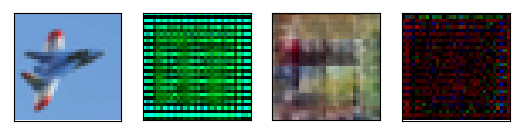

mse is 0.193001389503479
psnr is 7.1443956430040645
ssim is 0.01278339808247579


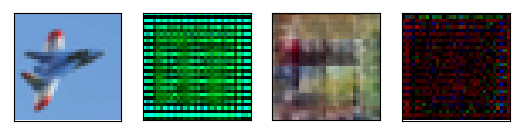

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.5325241684913635
psnr is 2.736606770831277
ssim is 0.01736467484674055


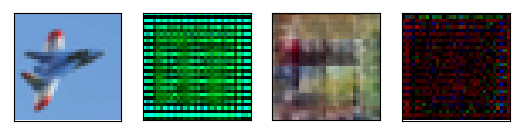

mse is 0.5082417130470276
psnr is 2.9392969386511005
ssim is 0.010954350447860195


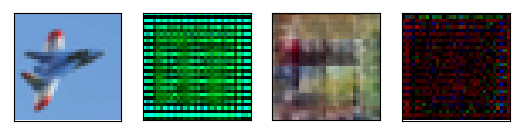

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.8372423648834229
psnr is 0.7714880425882414
ssim is 0.00554097460320898


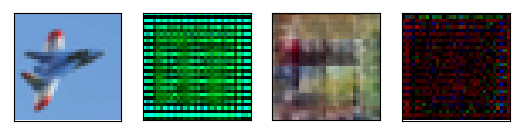

mse is 0.6620791554450989
psnr is 1.7909008500446206
ssim is 0.006839767072214248


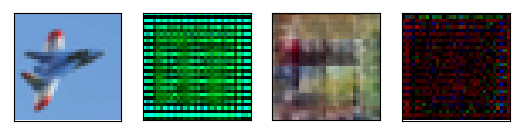

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.4412873685359955
psnr is 3.552785036736493
ssim is -0.0070913269977111735


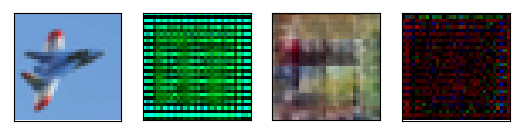

mse is 0.5064887404441833
psnr is 2.954302048294914
ssim is 0.012061638677564353


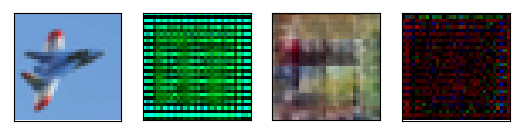

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.2303798347711563
psnr is 6.375555375356394
ssim is 0.017659637264100077


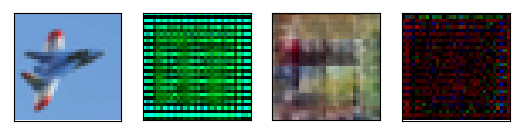

mse is 2.720754623413086
psnr is -4.3468937584702765
ssim is -1.0586943956023182e-05


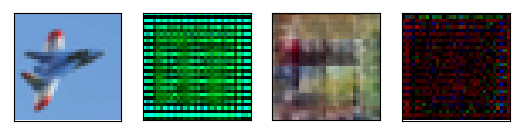

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.46095767617225647
psnr is 3.36338948468621
ssim is 0.001198368529522707


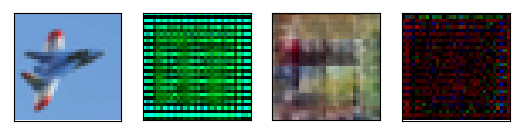

mse is 0.391195684671402
psnr is 4.076059446148413
ssim is 0.014566120723787731


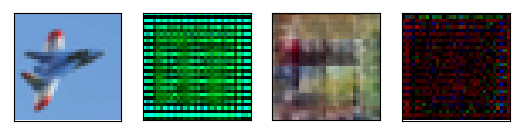

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.27111920714378357
psnr is 5.668397142119264
ssim is -0.011651470931691539


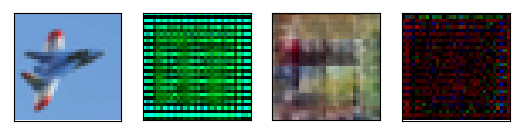

mse is 0.22808797657489777
psnr is 6.418976075107322
ssim is -0.0037293721392613003


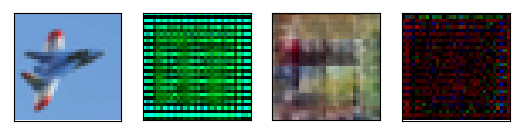

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.29052743315696716
psnr is 5.368128529253571
ssim is 0.018273772220710152


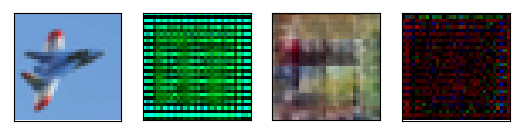

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.5217148661613464
psnr is 2.825667879664241
ssim is -0.0024108624222475084


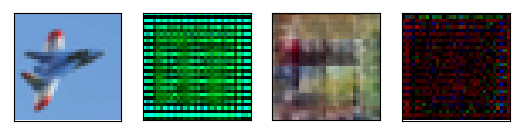

mse is 0.37086930871009827
psnr is 4.307791052245166
ssim is 0.012135106528194804


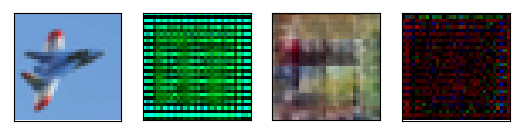

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.5077248811721802
psnr is 2.943715533749744
ssim is -0.011639121062068344


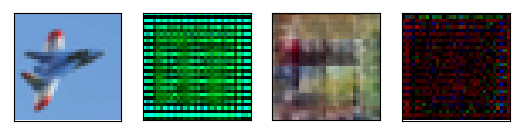

mse is 0.21632416546344757
psnr is 6.648949630333332
ssim is -0.008970213027279452


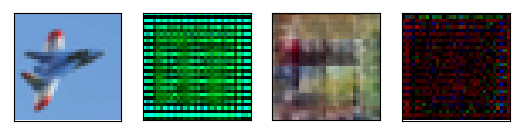

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.3716159760951996
psnr is 4.299056235781725
ssim is -0.01644811011592799


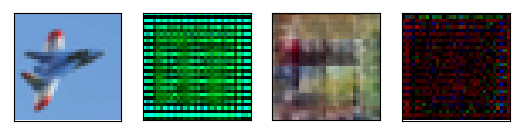

In [46]:

# 论文<Image to Perturbation: An Image Transformation Network for Generating Visually Protected Images for Privacy-Preserving Deep Neural Networks>
test_attack(g_model="UNet",g_path="output_second/g",attack_model="myObfuscator",attack_path="Cifar10_myObfuscator/secondpaper/myObfuscator")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.0995769202709198
psnr is 10.018413097740401
ssim is 0.13867570490275508


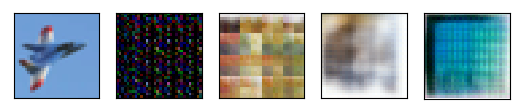

mse is 0.1223127469420433
psnr is 9.125282801827288
ssim is 0.06332154972479426


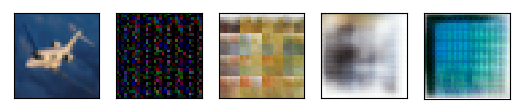

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.10537856072187424
psnr is 9.772477373898825
ssim is 0.03702169452882889


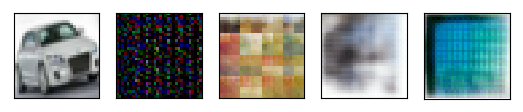

mse is 0.0755588710308075
psnr is 11.21714539749059
ssim is -0.04663224345227959


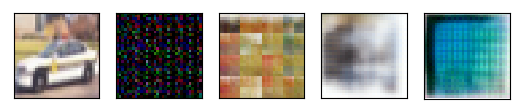

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.1626061350107193
psnr is 7.888630728192066
ssim is -0.05099582343070329


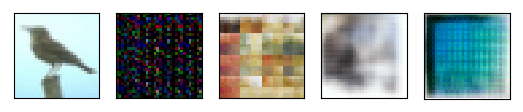

mse is 0.15331228077411652
psnr is 8.144230554599561
ssim is 0.05697128648123356


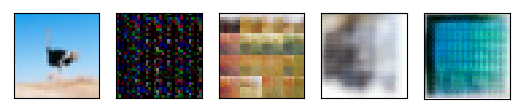

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.11560561507940292
psnr is 9.370210712893945
ssim is 0.09511738735584621


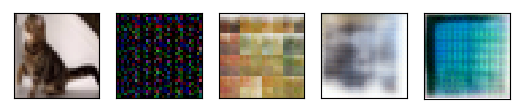

mse is 0.11394834518432617
psnr is 9.432919774825892
ssim is 0.007801792933948621


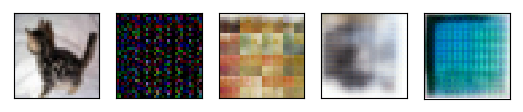

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.07341254502534866
psnr is 11.34229719787611
ssim is -0.011716818188977764


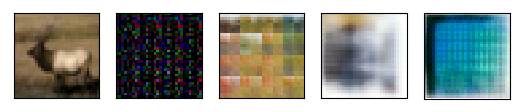

mse is 0.10216585546731949
psnr is 9.9069422416016
ssim is 0.07105356557285676


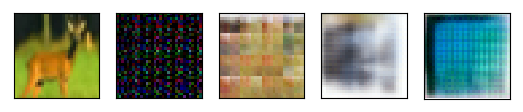

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.06054149195551872
psnr is 12.179468807024538
ssim is 0.08180229014184506


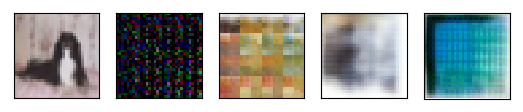

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.07102929800748825
psnr is 11.485624774999952
ssim is 0.07876183787341715
mse is 0.05595258250832558
psnr is 12.521798636801943
ssim is 0.09657926271654266


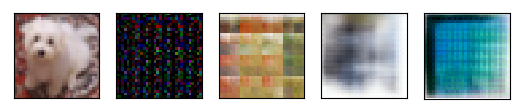

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


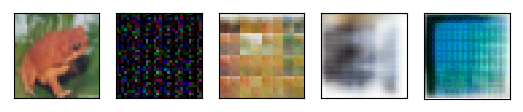

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.057334501296281815
psnr is 12.415839606953043
ssim is 0.01794327613729693


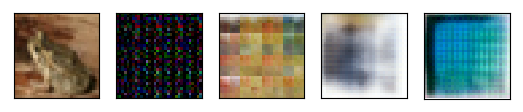

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.06879493594169617
psnr is 11.624435294028807
ssim is 0.07728966982500467


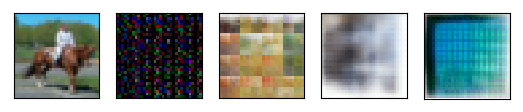

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.1216173991560936
psnr is 9.15004288410887
ssim is 0.03612682263220067


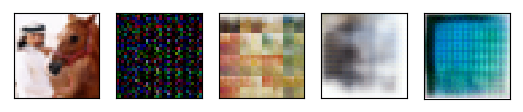

mse is 0.10086967796087265
psnr is 9.962393657092697
ssim is 0.054603455273521576


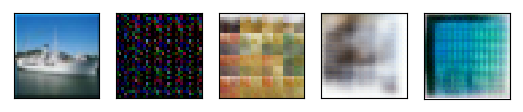

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.06424929946660995
psnr is 11.921316032409369
ssim is 0.12089379168027689


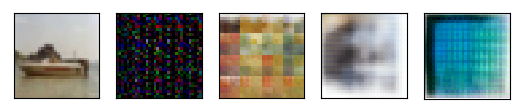

mse is 0.10567092895507812
psnr is 9.760444746690597
ssim is -0.01650128082857305


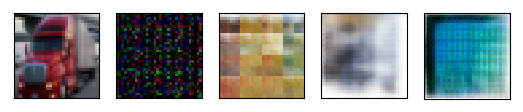

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.1334991306066513
psnr is 8.745215625687946
ssim is 0.06954761872919664


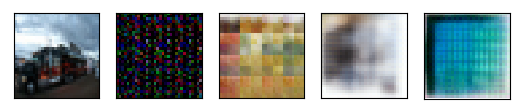

In [37]:
import numpy as np

test_attack(g_model="myObfuscator",g_path="output/g")
import numpy as np


mse is 0.010207313112914562
psnr is 19.910885628889684
ssim is 0.4613027927386611
mse is 0.011035325936973095
psnr is 19.57214835086068
ssim is 0.38230529578834477


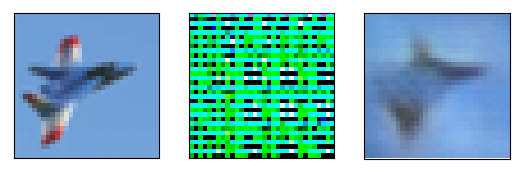

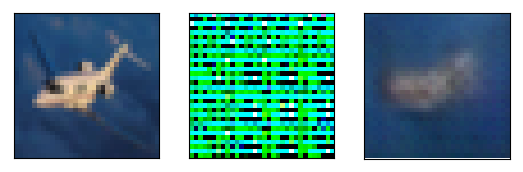

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.01828473061323166
psnr is 17.37911433687917
ssim is 0.5611917780164141


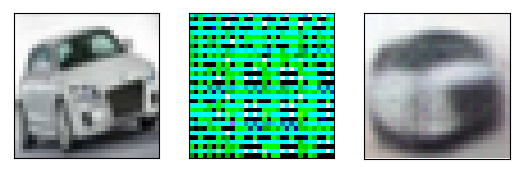

mse is 0.04031839221715927
psnr is 13.944967946463054
ssim is 0.19946140457606024


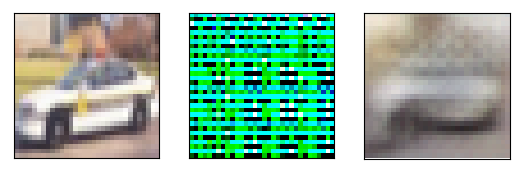

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.014874701388180256
psnr is 18.275517440375484
ssim is 0.7195020824345166


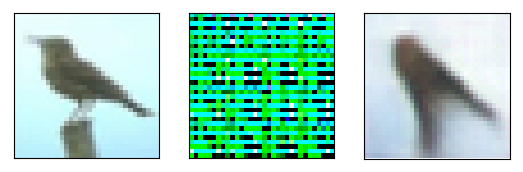

mse is 0.011343990452587605
psnr is 19.4523414767496
ssim is 0.6112310436318494


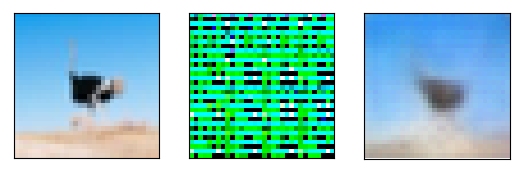

mse is 0.050770699977874756
psnr is 12.943868489169857
ssim is 0.41901944661605045
mse is 0.033144716173410416
psnr is 14.795856956040447
ssim is 0.5028809819617407


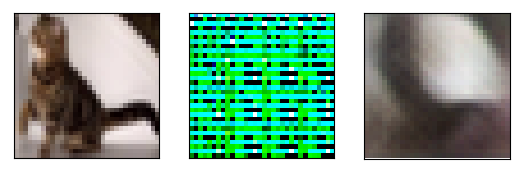

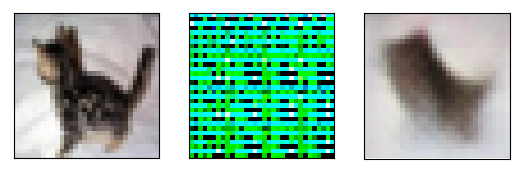

mse is 0.02156512625515461
psnr is 16.662479948907887
ssim is 0.33337048452583606


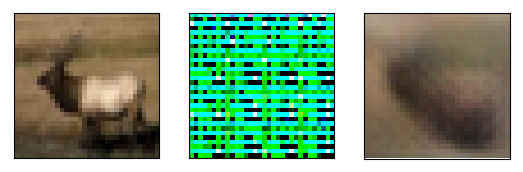

mse is 0.025567853823304176
psnr is 15.923057253101675
ssim is 0.23441690252056188


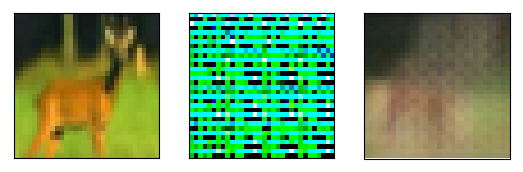

mse is 0.020338227972388268
psnr is 16.91686888942213
ssim is 0.45835323079700924


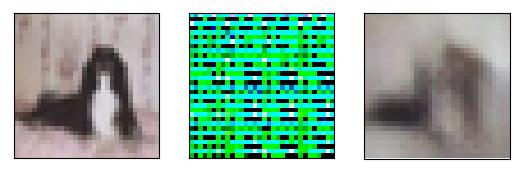

mse is 0.021499985828995705
psnr is 16.675618263351385
ssim is 0.39535018026055857


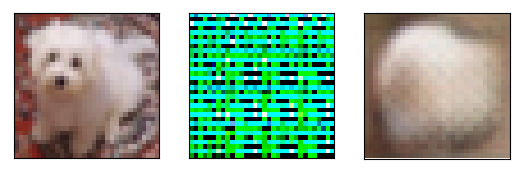

mse is 0.028359845280647278
psnr is 15.472961428100014
ssim is 0.3230771750788242
mse is 0.015429831109941006
psnr is 18.116388275610962
ssim is 0.2670332559798873


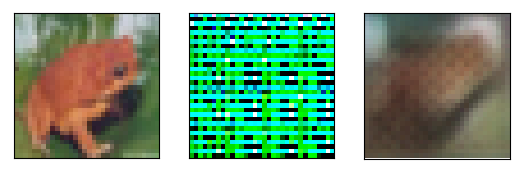

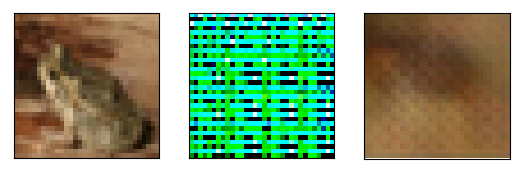

mse is 0.025509661063551903
psnr is 15.932953116452865
ssim is 0.28488224657695166


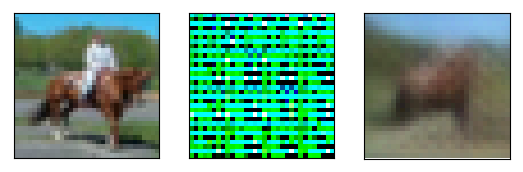

mse is 0.06261024624109268
psnr is 12.0335458816605
ssim is 0.3263107801325775


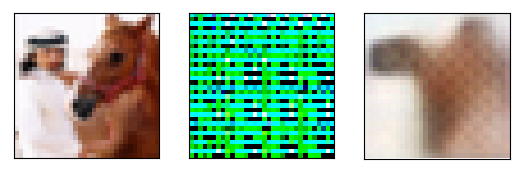

mse is 0.019273214042186737
psnr is 17.15045855433123
ssim is 0.36640834863966204
mse is 0.012438814155757427
psnr is 19.052210207833824
ssim is 0.641456836959993


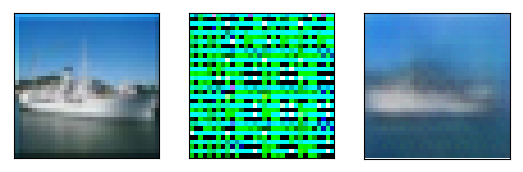

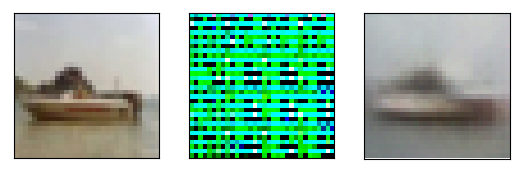

mse is 0.028590241447091103
psnr is 15.437821769716171
ssim is 0.28082638137078864


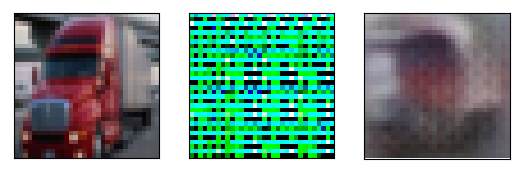

mse is 0.02756388485431671
psnr is 15.596595729802235
ssim is 0.2889149579198834


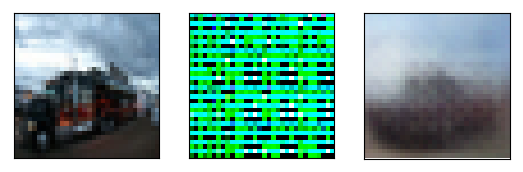

In [20]:
test_attack(g_model="Obfuscator",g_path="output2/g",d_model = "vgg16")

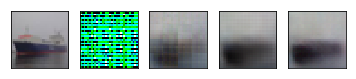

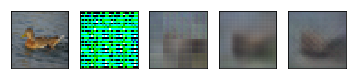

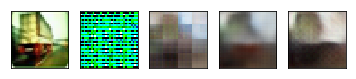

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


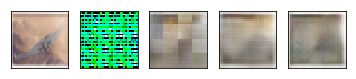

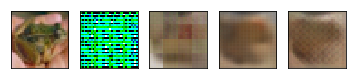

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


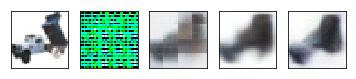

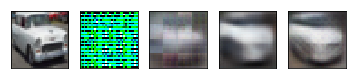

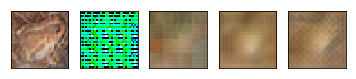

In [11]:
test_attack(g_model="Obfuscator",g_path="output2/g",d_model = "vgg16")

In [ ]:
def test_attack(g_model="",g_path="",d_model = "MyNet",d_path="Cifar10_vgg19/no/vgg16",attack_model="",attack_path=""):
    if g_model == "UNet":
        g = UNet(3)
    elif g_model == "myObfuscator":
        g = myObfuscator()
    elif g_model == "Obfuscator":
        g = Obfuscator()
    # 加载转换器
    model_para, _ = fluid.load_dygraph(g_path)
    g.load_dict(model_para)
    
    if d_model == "MyNet":
        d = MyNet(10)
    elif d_model == "":
        d = MyVGG16()
    # 加载识别器
    model_para, _ = fluid.load_dygraph(d_path)
    d.load_dict(model_para)

    if attack_model == "myObfuscator":
        # attack = myObfuscator()

        attack1 = myObfuscator()
        attack2 = UNet(3)
        attack3 = myObfuscator()

    elif attack_model == "Obfuscator":
        attack = Obfuscator()
    elif attack_model == "UNet":
        attack = UNet(3)
    elif attack_model == "":
        pass
    # 加载攻击模型

    model_para, _ = fluid.load_dygraph("Cifar10_UNet/firstpaper/UNet1")
    attack1.load_dict(model_para)
    model_para, _ = fluid.load_dygraph("Cifar10_UNet/firstpaper/UNet2")
    attack2.load_dict(model_para)
    model_para, _ = fluid.load_dygraph(attack_path)
    attack3.load_dict(model_para)

    for batch_id, data in enumerate(test_loader()):
        x_data = data[0]
        y_data = data[1]

        g_img = g(x_data)
        
        pre = d(x_data)
        re_pre = d(g_img)

        re_img1 = attack1(g_img)
        re_img2 = attack2(g_img)
        re_img3 = 0.5*re_img1 + 0.5*re_img2

        re_img = attack3(g_img)
        
        image_grid(x_data.numpy().transpose(0,2,3,1)[0],1,4,1)
        image_grid(g_img.numpy().transpose(0,2,3,1)[0],1,4,2)
        image_grid(re_img.numpy().transpose(0,2,3,1)[0],1,4,3)
        image_grid(re_img3.numpy().transpose(0,2,3,1)[0],1,4,4)

        plt.show()

        if batch_id > 30 :
            break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


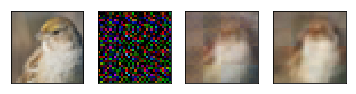

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


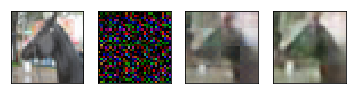

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


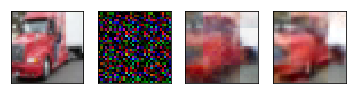

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


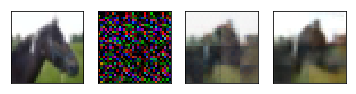

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


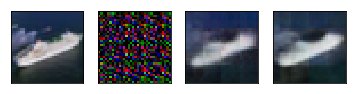

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


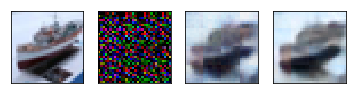

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


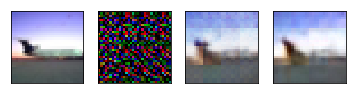

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


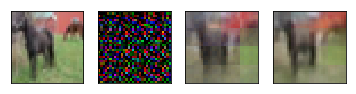

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


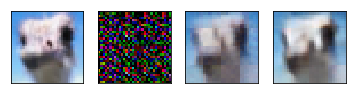

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


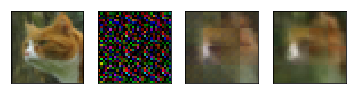

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


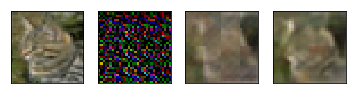

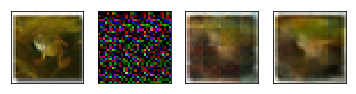

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


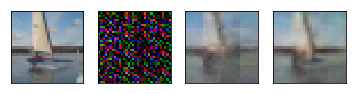

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


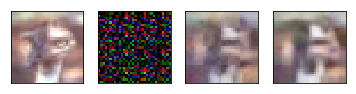

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


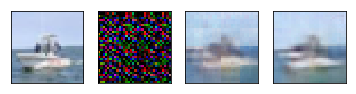

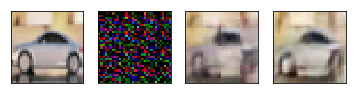

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


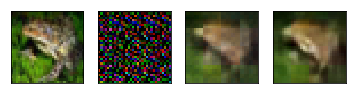

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


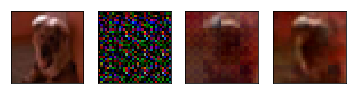

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


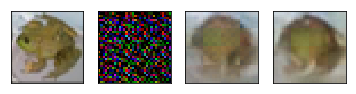

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


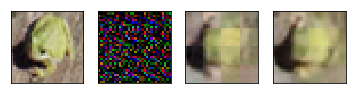

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


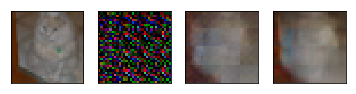

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


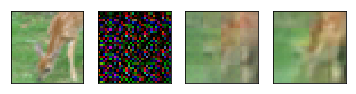

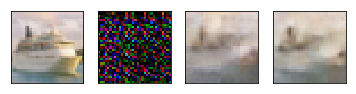

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


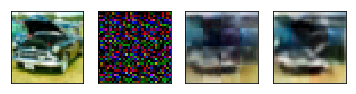

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


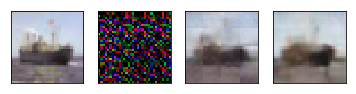

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


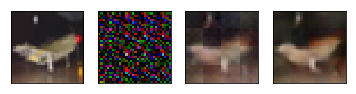

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


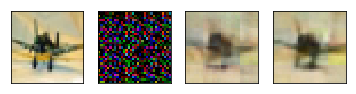

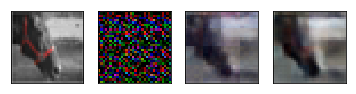

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


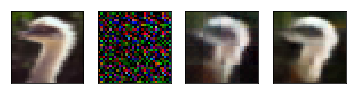

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


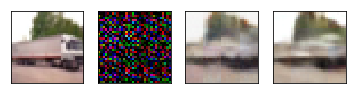

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


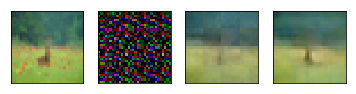

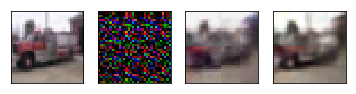

In [ ]:
import numpy as np

# test_attack(g_model="myObfuscator",g_path="output/g",attack_model="UNet",attack_path="Cifar10_UNet/firstpaper/UNet")
# 论文<Privacy Aware Offloading of Deep Neural Networks>
test_attack(g_model="myObfuscator",g_path="output/g",attack_model="myObfuscator",attack_path="Cifar10_myObfuscator/firstpaper/myObfuscator")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


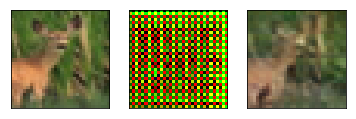

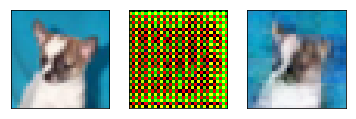

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


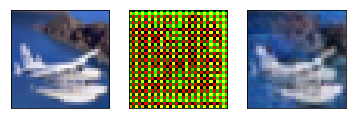

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


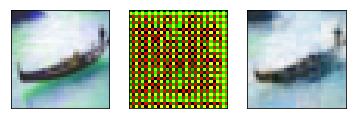

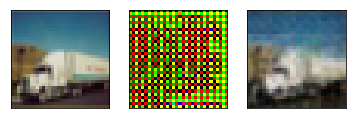

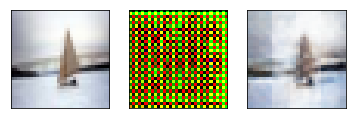

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


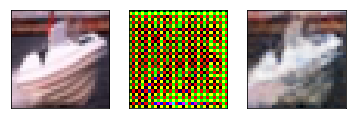

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


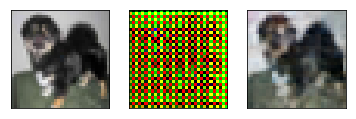

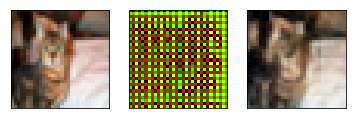

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


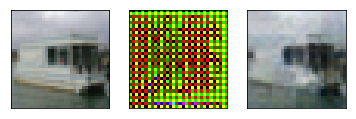

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


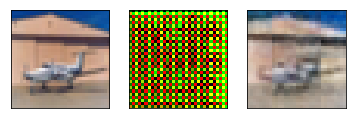

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


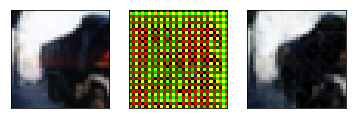

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


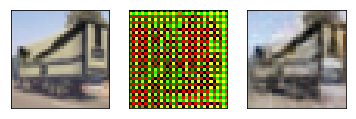

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


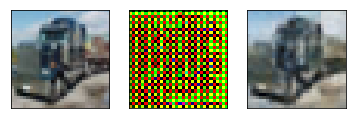

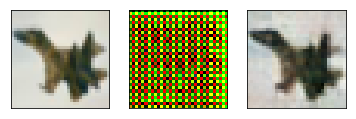

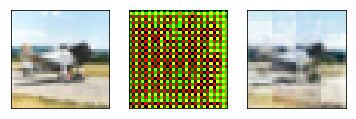

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


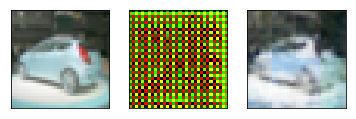

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


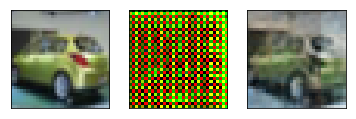

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


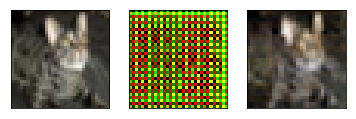

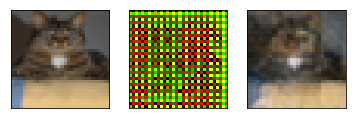

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


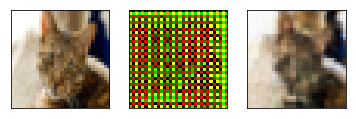

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


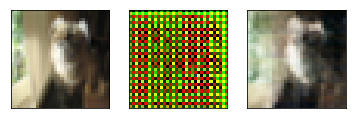

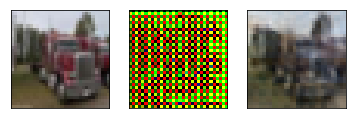

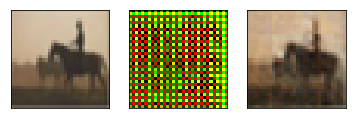

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


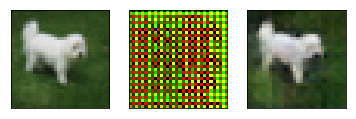

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


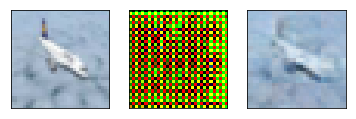

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


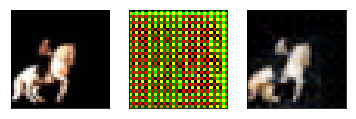

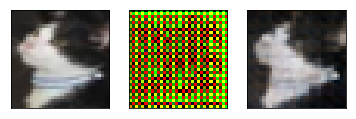

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


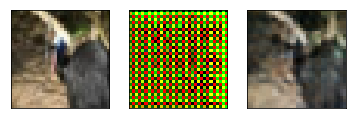

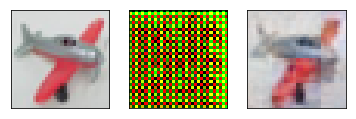

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


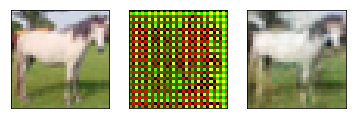

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


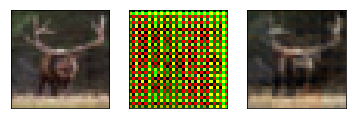

In [ ]:
import numpy as np

# 论文<Image to Perturbation: An Image Transformation Network for Generating Visually Protected Images for Privacy-Preserving Deep Neural Networks>
test_attack(g_model="UNet",g_path="output_second/g",attack_model="myObfuscator",attack_path="Cifar10_myObfuscator/secondpaper/myObfuscator")

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 